### Demographics API

Below we have the code that retrieves the data from the  Mechanical Turk Tracker Demographics API.

In [1]:
# Render our plots inline
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
!sudo -H pip3 install -U pip matplotlib pandas numpy seaborn xlwt

Requirement already up-to-date: pip in /usr/local/lib/python3.5/dist-packages (20.0.2)
Requirement already up-to-date: matplotlib in /usr/local/lib/python3.5/dist-packages (3.0.3)
Requirement already up-to-date: pandas in /usr/local/lib/python3.5/dist-packages (0.24.2)
Requirement already up-to-date: numpy in /usr/local/lib/python3.5/dist-packages (1.18.2)
Requirement already up-to-date: seaborn in /usr/local/lib/python3.5/dist-packages (0.9.1)
Requirement already up-to-date: xlwt in /usr/local/lib/python3.5/dist-packages (1.3.0)


In [3]:
import pandas as pd
import matplotlib
import numpy as np
import seaborn as sns

In [4]:

df = pd.read_csv("mturk_surveys.csv")
df.drop(df.columns[0], axis=1, inplace=True) # drop the "index" column
# We now transform our API answer into a flat table
# and set the right data types
df["hit_answered_date"]=pd.to_datetime(df["hit_answered_date"])
df["hit_creation_date"]=pd.to_datetime(df["hit_creation_date"])
df["household_income"]=df["household_income"].astype("category")
df["household_size"]=df["household_size"].astype("category")
df["location_country"]=df["location_country"].astype("category")
df["marital_status"]=df["marital_status"].astype("category")
df['date'] = pd.to_datetime(df['hit_answered_date'].apply(lambda x : x.date()))
df['time'] = df['hit_answered_date'].dt.round('min').apply(lambda x : x.time())
df.dtypes

gender                             object
hit_answered_date          datetime64[ns]
hit_creation_date          datetime64[ns]
household_income                 category
household_size                   category
location_city                      object
location_country                 category
location_region                    object
marital_status                   category
post_to_completion_secs           float64
worker_id                          object
year_of_birth                       int64
date                       datetime64[ns]
time                               object
dtype: object

In [5]:
# We "freeze" the study to use only data until Oct 31st 2019
df = df[ df["hit_answered_date"] <= pd.to_datetime('2019-10-31') ]

In [6]:
import datetime
import time

minDate = min(df['hit_answered_date'])
maxDate = max(df['hit_answered_date'])


# The following are for setting up the x-axis in the plots that
# show demographics over time
min_x = minDate.toordinal()
max_x = maxDate.toordinal()
ticks = 6
steps = (max_x-min_x)/ticks

days = (maxDate - minDate).days
print(minDate)
print(maxDate)
print(days)

2015-03-26 11:47:28.877000
2019-10-30 23:58:23.077000
1679


In [7]:
df['ttl'] = (df['hit_answered_date'] - df['hit_creation_date']).dt.total_seconds()

In [8]:
df['hour'] = df['hit_creation_date'].dt.hour

In [9]:
df['dow'] = df['hit_creation_date'].dt.dayofweek

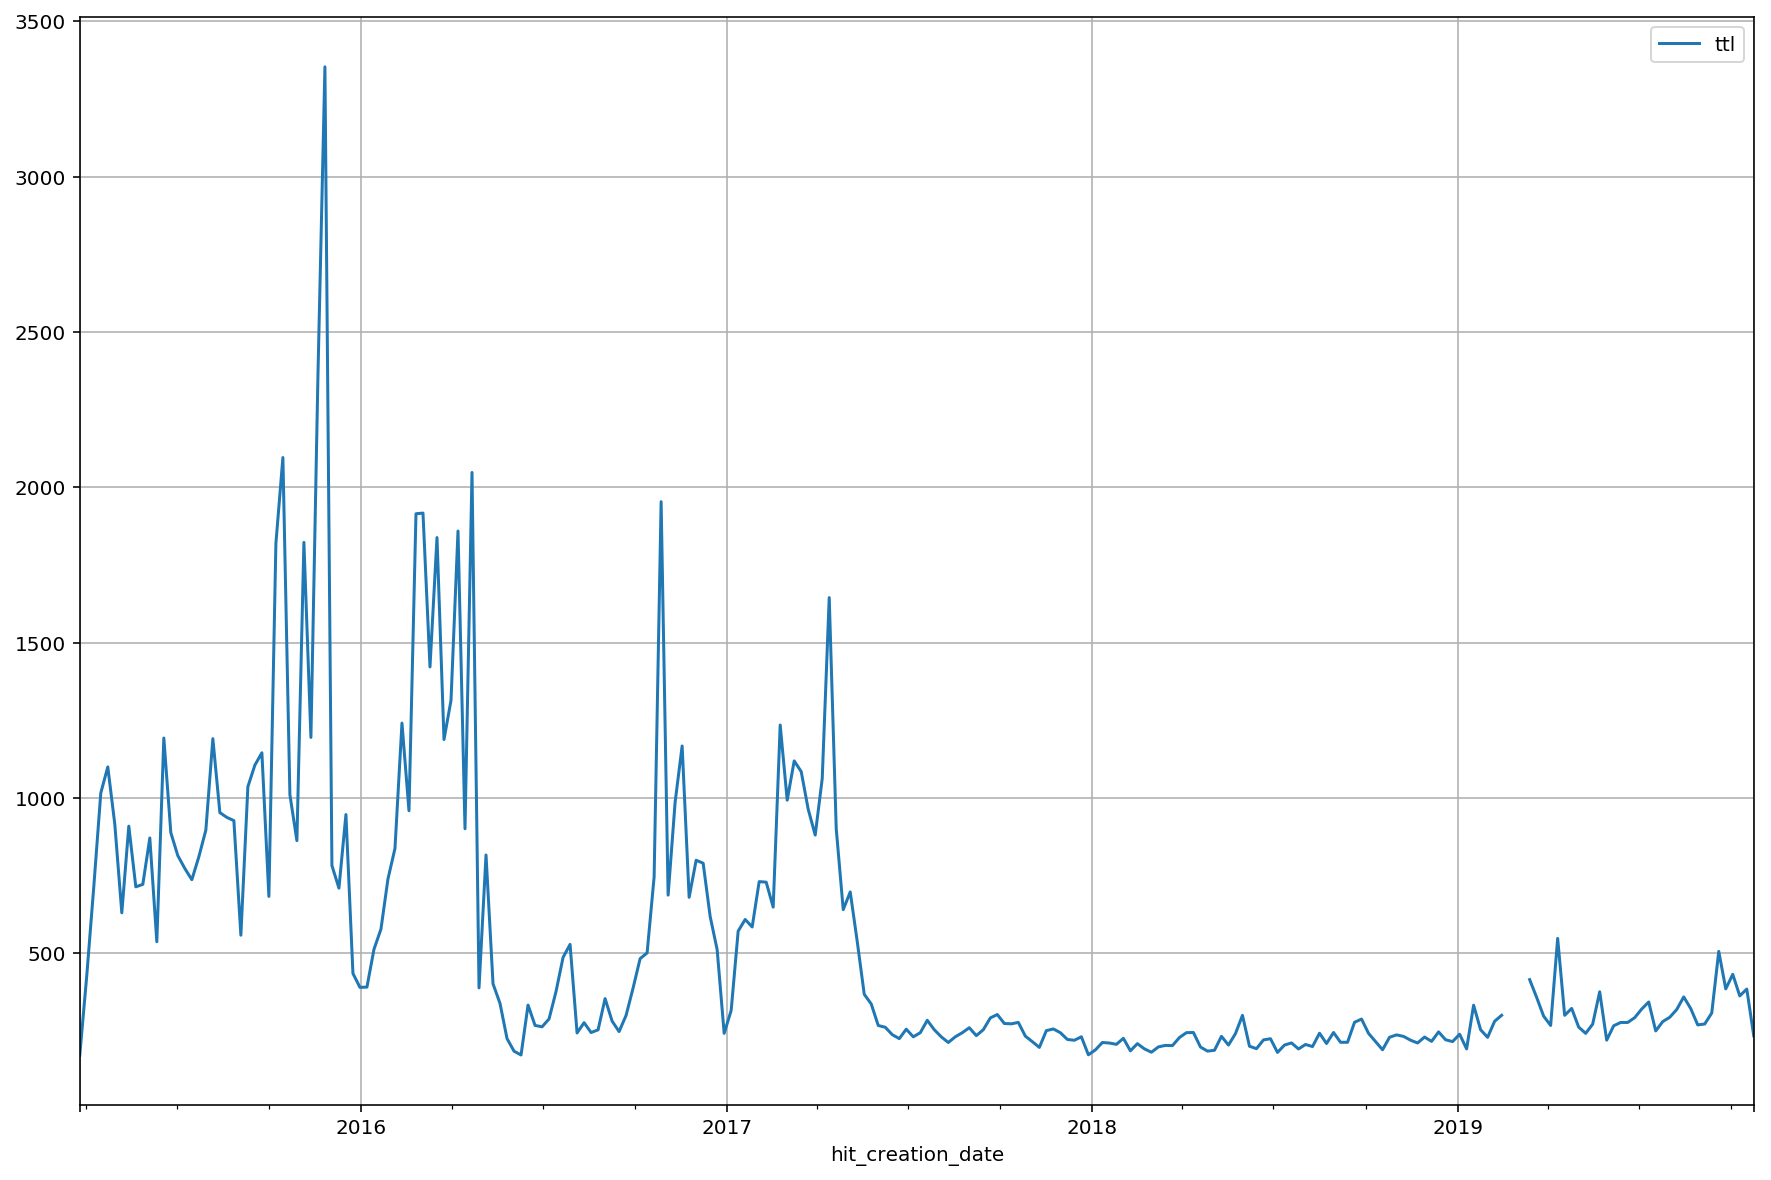

In [10]:
ax = df.pivot_table(
    index='hit_creation_date',
    values='ttl',
    aggfunc = np.median
).resample('7D').median().plot( figsize=(15,10), grid=True)


# sns.violinplot(data=df, x='hour', y='ttl', ylim=(0,100))

In [11]:
print("Unique workers in the sample:", len(set(df.worker_id)))

Unique workers in the sample: 68803


In [12]:
# Fix a data quality issue
#fix = list(df[df.gender=='Female'].index)[0]
#df = df.set_value(fix, 'gender', 'female')

In [13]:
# df.head(5)

### Exploratory plots

In [14]:
!sudo -H pip3 install -U matplotlib

Requirement already up-to-date: matplotlib in /usr/local/lib/python3.5/dist-packages (3.0.3)


In [15]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
mpl.__version__

'3.0.3'

In [16]:
# !sudo -H pip3 install -U seaborn

In [17]:
import seaborn as sns
sns.__version__

'0.9.1'

In [18]:
mpl.rc("figure", figsize=(16, 8))
mpl.rcParams.update({'font.size': 22})
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
sns.set_style("whitegrid")

#### Countries of the workers

In [19]:
# Let's see the top countries
country = 100* df['location_country'].value_counts() / len(df)

In [20]:
pd.DataFrame(country.head(30))

location_country
US         72.649916
IN         18.563995
CA          1.374333
GB          0.960303
IT          0.428243
DE          0.374481
BR          0.367065
PH          0.317011
VE          0.284259
FR          0.268193
ES          0.209487
ZZ          0.196510
MX          0.185387
AU          0.152017
KE          0.127917
AE          0.119265
RO          0.109378
NL          0.106288
TR          0.105670
JP          0.100727
NG          0.099491
TH          0.096401
ID          0.093311
RU          0.092693
PT          0.089604
GR          0.087750
IE          0.084660
MK          0.082806
UA          0.073537
NZ          0.071065

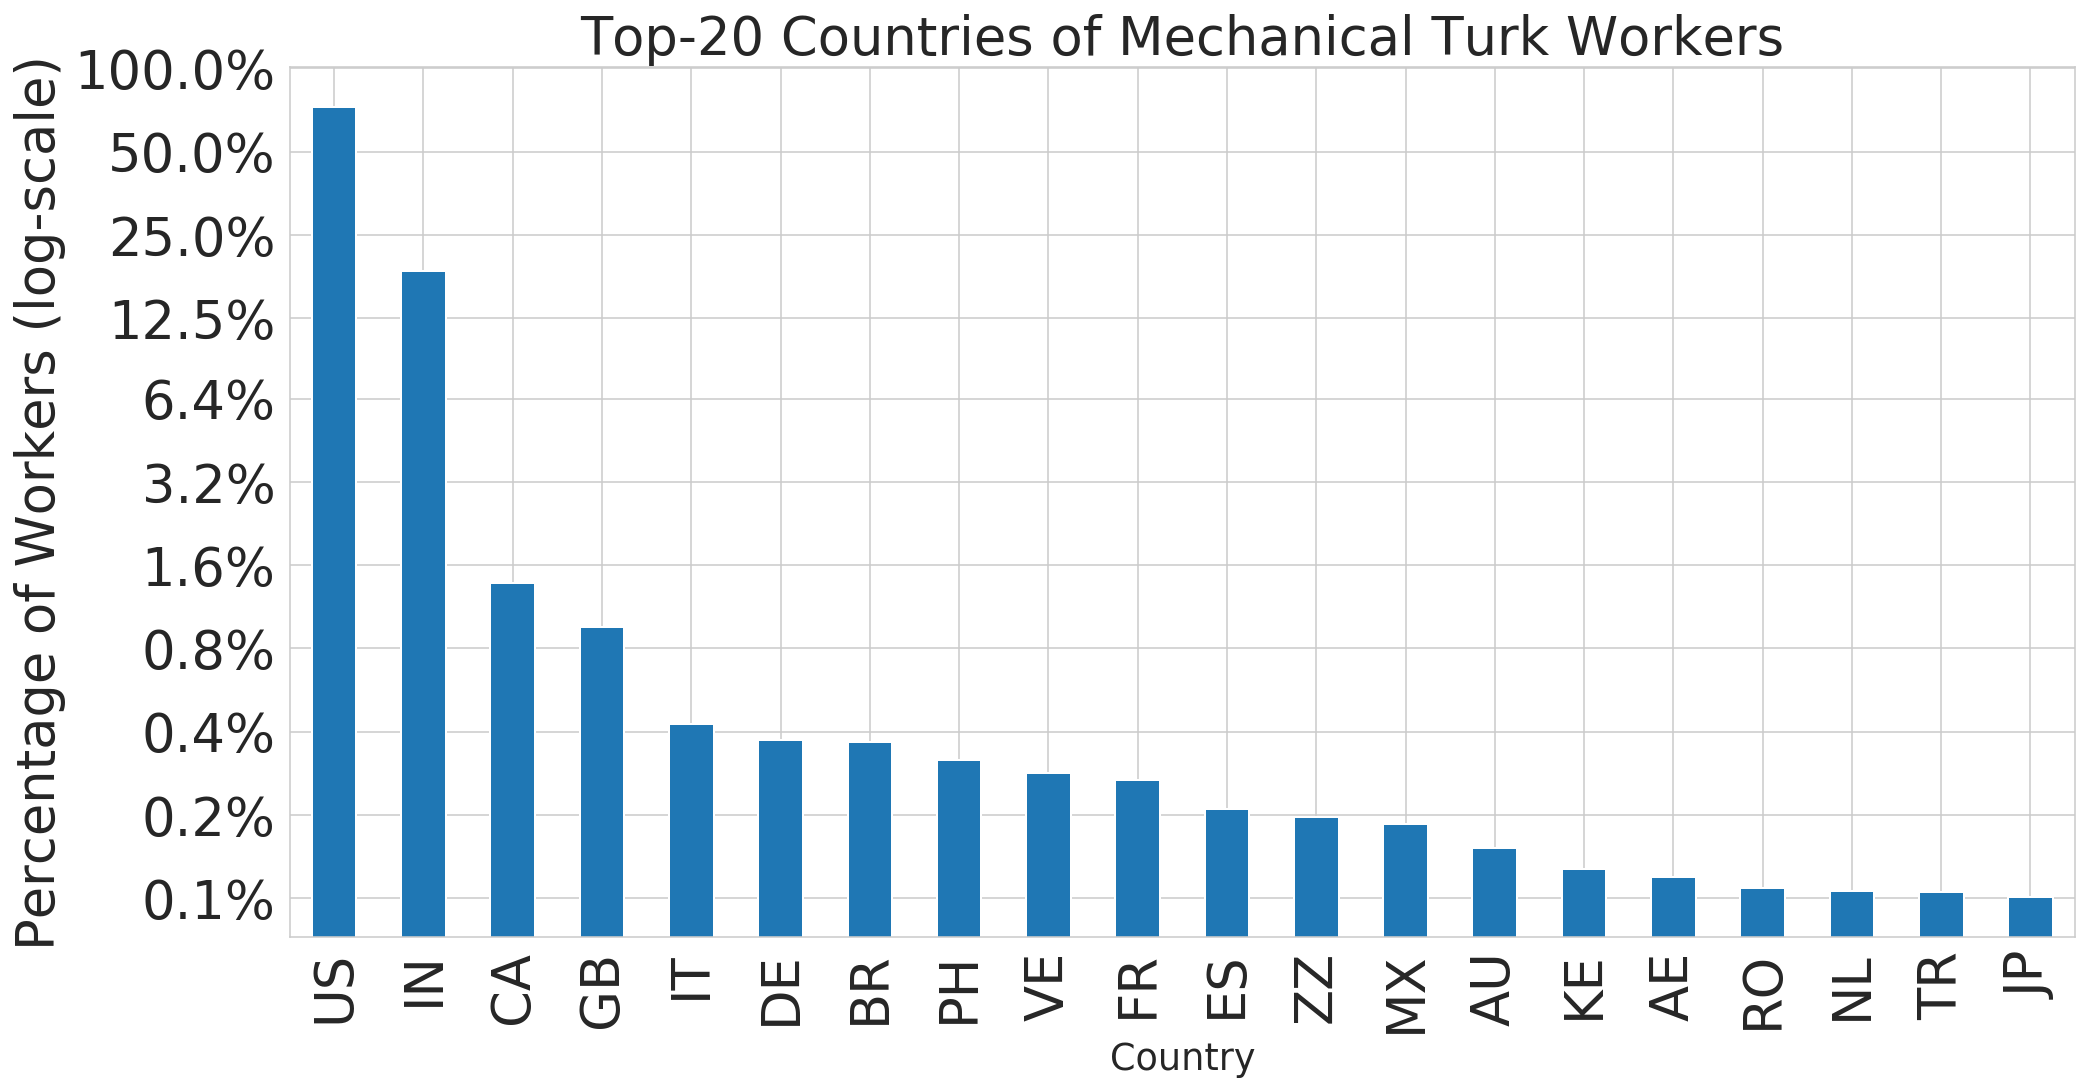

In [21]:
ax = country.head(20).plot.bar(log=True, fontsize='large', color=sns.color_palette(n_colors=1))
ax.set_title("Top-20 Countries of Mechanical Turk Workers", fontsize='large')
ax.set_xlabel("Country", fontsize='small')
ax.set_ylabel("Percentage of Workers (log-scale)", fontsize='large')

fmt = '%.1f%%' # Format you want the ticks, e.g. '40%'
yticks = mtick.FormatStrFormatter(fmt)
ax.yaxis.set_major_formatter(yticks)
ax.set_yticks([0.1, 0.2, 0.4, 0.8, 1.6, 3.2, 6.4, 12.5, 25, 50, 100])
#ax.yaxis.set_major_formatter(mtick.PercentFormatter())

fig = ax.get_figure()
fig.savefig('plots/countries.pdf', bbox_inches='tight')

In [22]:
country_table = pd.crosstab(index=df.date, columns=df.location_country, 
                            values='worker_id', aggfunc=np.count_nonzero, normalize='index')
# country_table

In [23]:
def time_plot(data, title, filename, confidence=True, legend=False):
        # Compute the mean, and the 10%, 25%, 75%, and 90% percentile
    # Values calculated over a rolling 30-day window
    # Plot lines are smoothed using a 7-day exponential weighted window
    m = data.rolling(window=30).mean().ewm(span=7).mean()
    s1 = data.rolling(window=30).quantile(quantile=0.25).ewm(span=7).mean()
    s2 = data.rolling(window=30).quantile(quantile=0.75).ewm(span=7).mean()
    #s3 = country_table['US'].rolling(window=30).quantile(quantile=0.1).ewm(span=7).mean()
    #s4 = country_table['US'].rolling(window=30).quantile(quantile=0.9).ewm(span=7).mean()

    ax = m.plot(fontsize='small')
    if confidence:
        ax = s1.plot(fontsize='small', color='#bbbbff', linestyle = '--', ax = ax)
        ax = s2.plot(fontsize='small', color='#bbbbff', linestyle = '--', ax = ax)
        
        
    #ax = s3.plot(fontsize='small', color='#eeeeff', linestyle = '--', ax = ax)
    #ax = s4.plot(fontsize='small', color='#eeeeff', linestyle = '--', ax = ax)

    ax.set_title(title, fontsize='large')
    ax.set_ylabel("Percentage", fontsize='small')
    ax.set_xlabel("Date", fontsize='small')
    
    fmt = '%3.1f%%' # Format you want the ticks, e.g. '40%'
    yticks = mtick.FormatStrFormatter(fmt)
    ax.yaxis.set_major_formatter(yticks)
    
    if legend:
        ax.legend( fontsize='small', fancybox=True, frameon = True)
        

            
          
    #ax.xaxis.set_ticks(np.arange(min_x, max_x, steps))
    #ax.yaxis.set_ticks(np.arange(0.55, 0.91, 0.05))
    fig = ax.get_figure()
    fig.savefig(filename, bbox_inches='tight')
    
    return ax


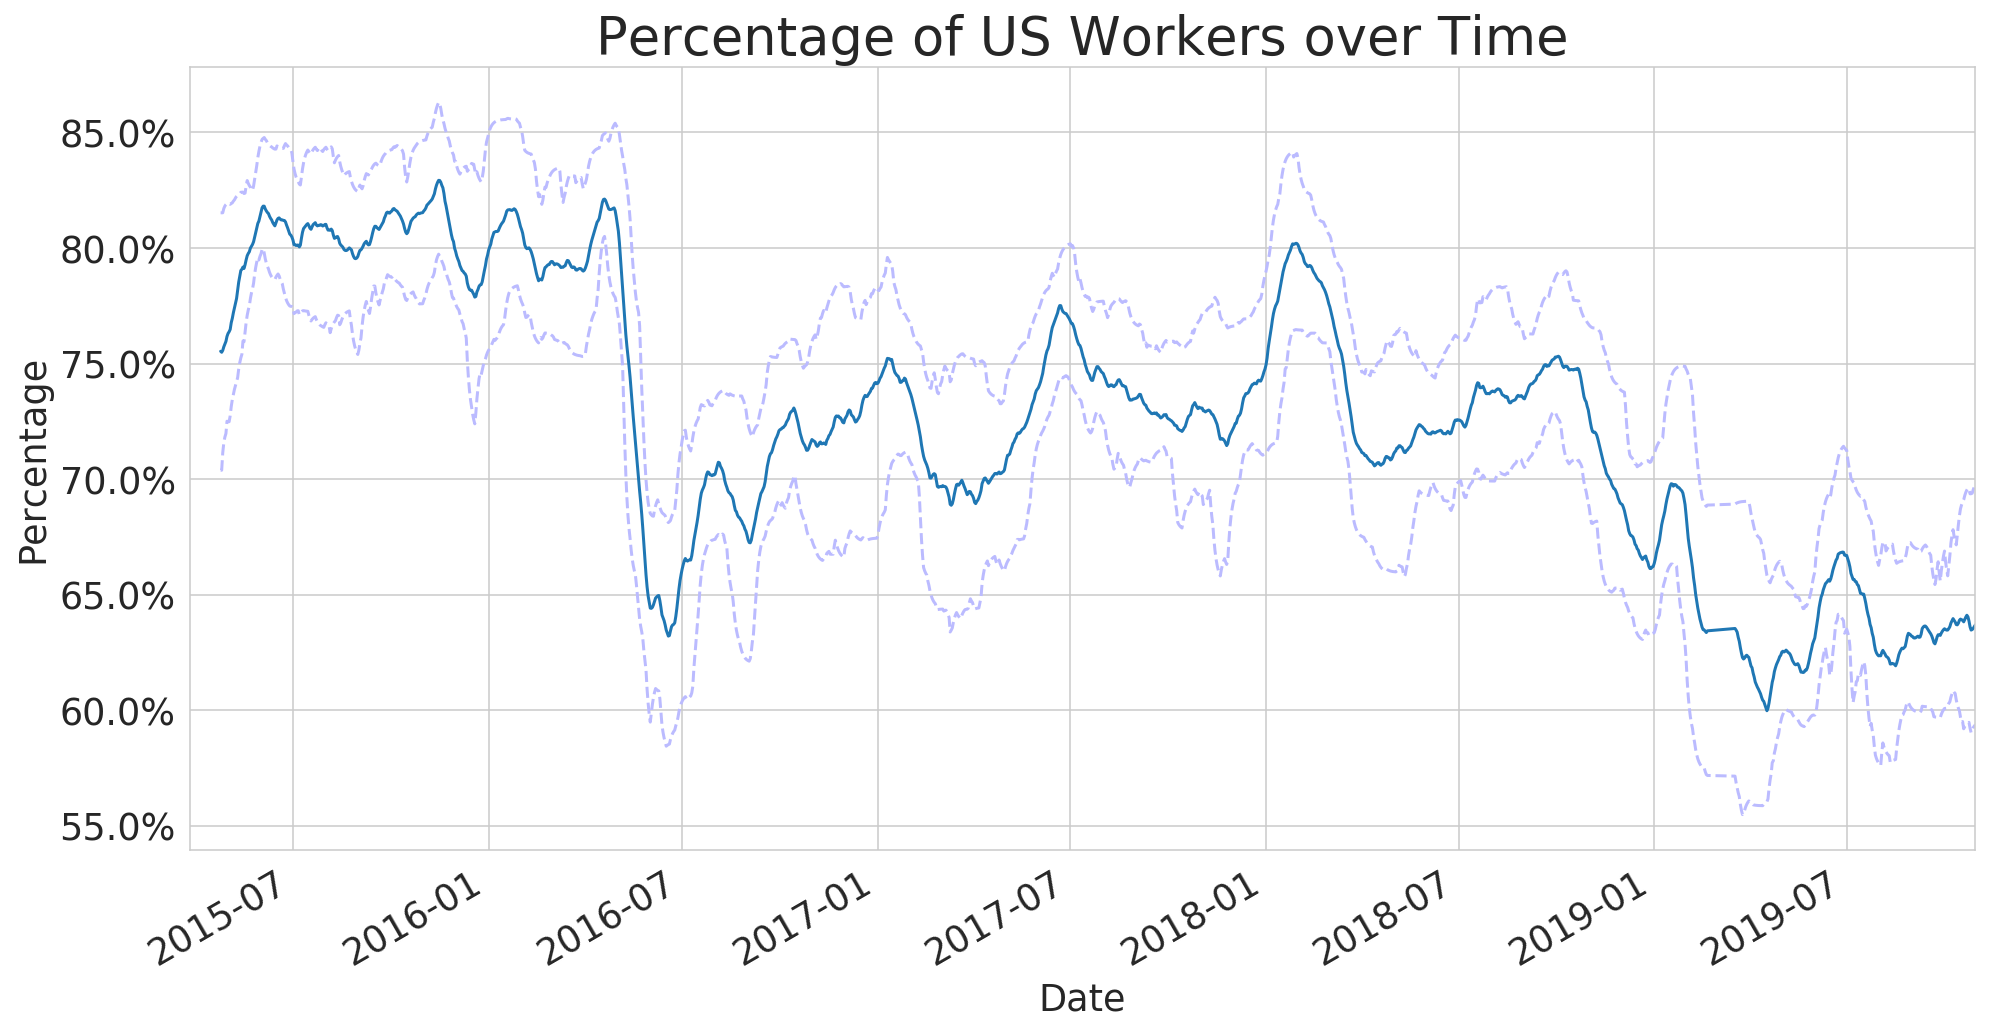

In [24]:
time_plot(100*country_table['US'], 'Percentage of US Workers over Time', 'plots/country-us.pdf')

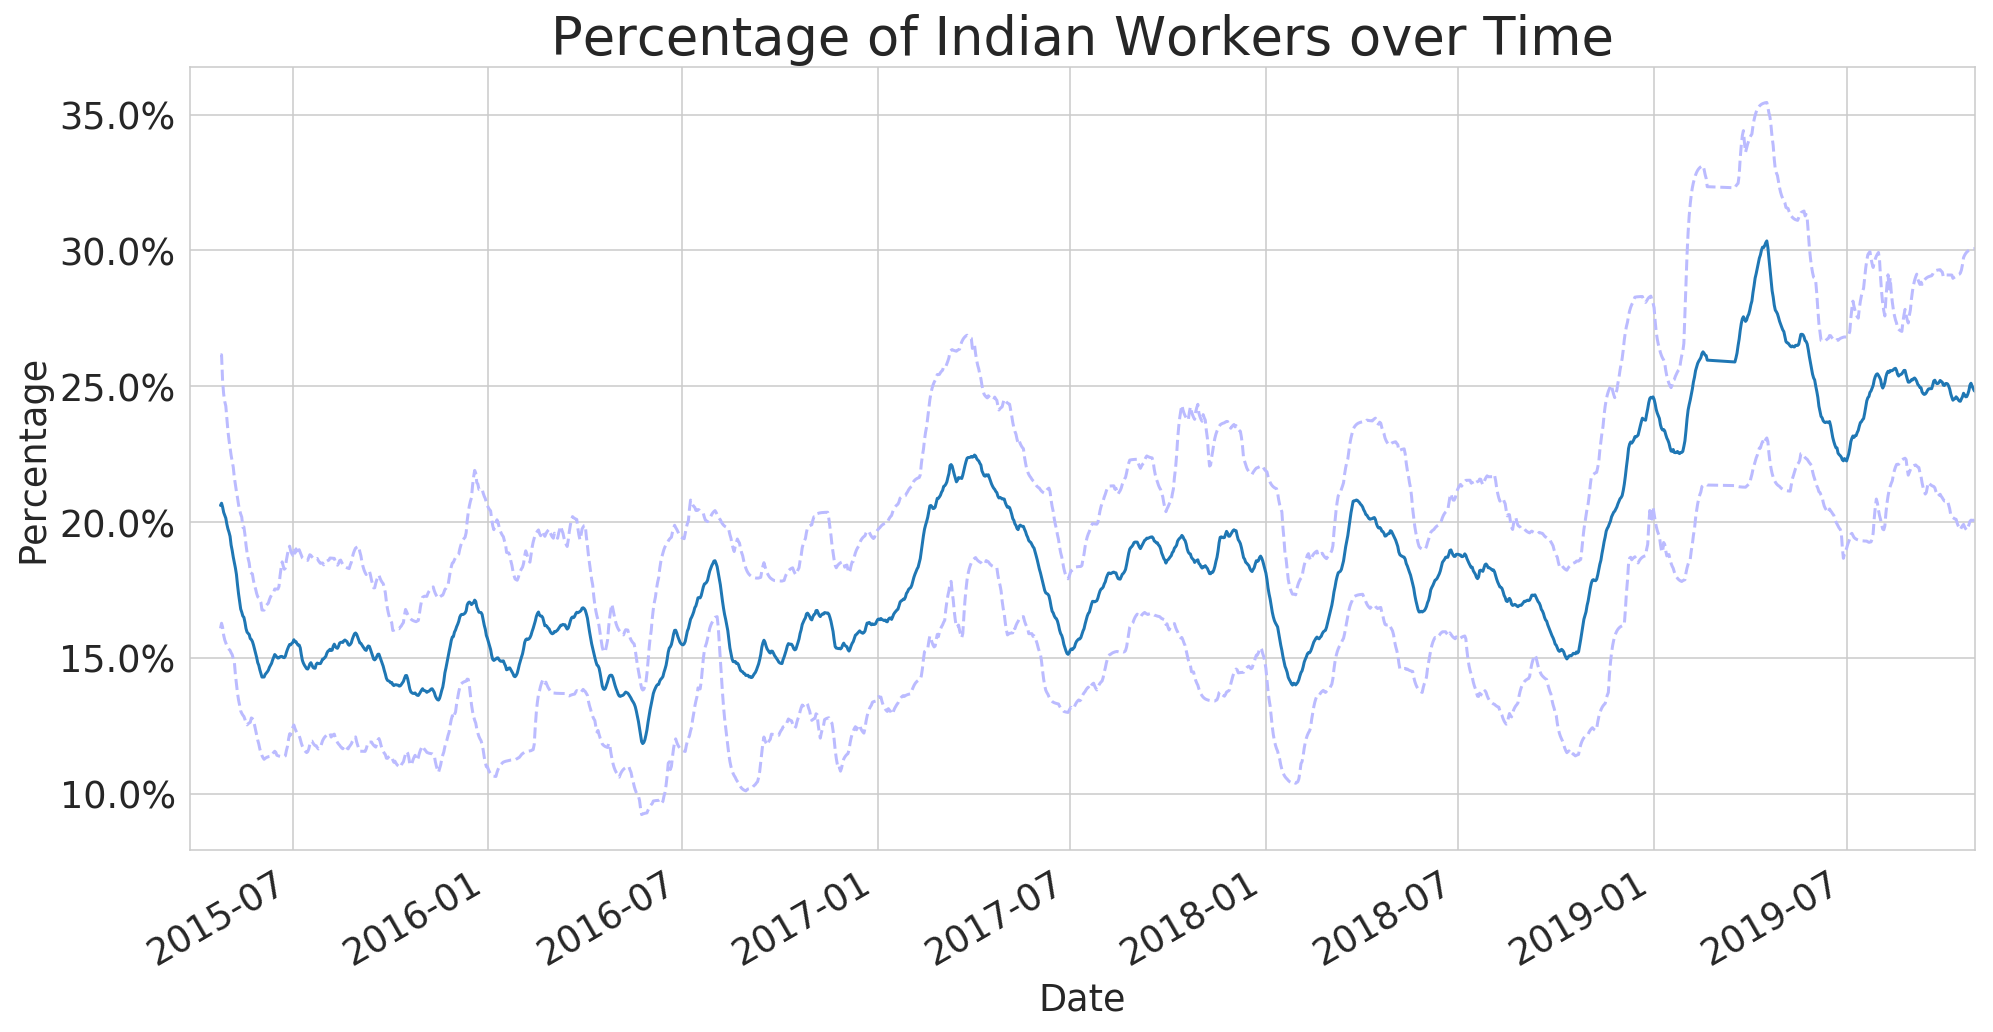

In [25]:
time_plot(100*country_table['IN'], 'Percentage of Indian Workers over Time', 'plots/country-in.pdf', confidence=True)


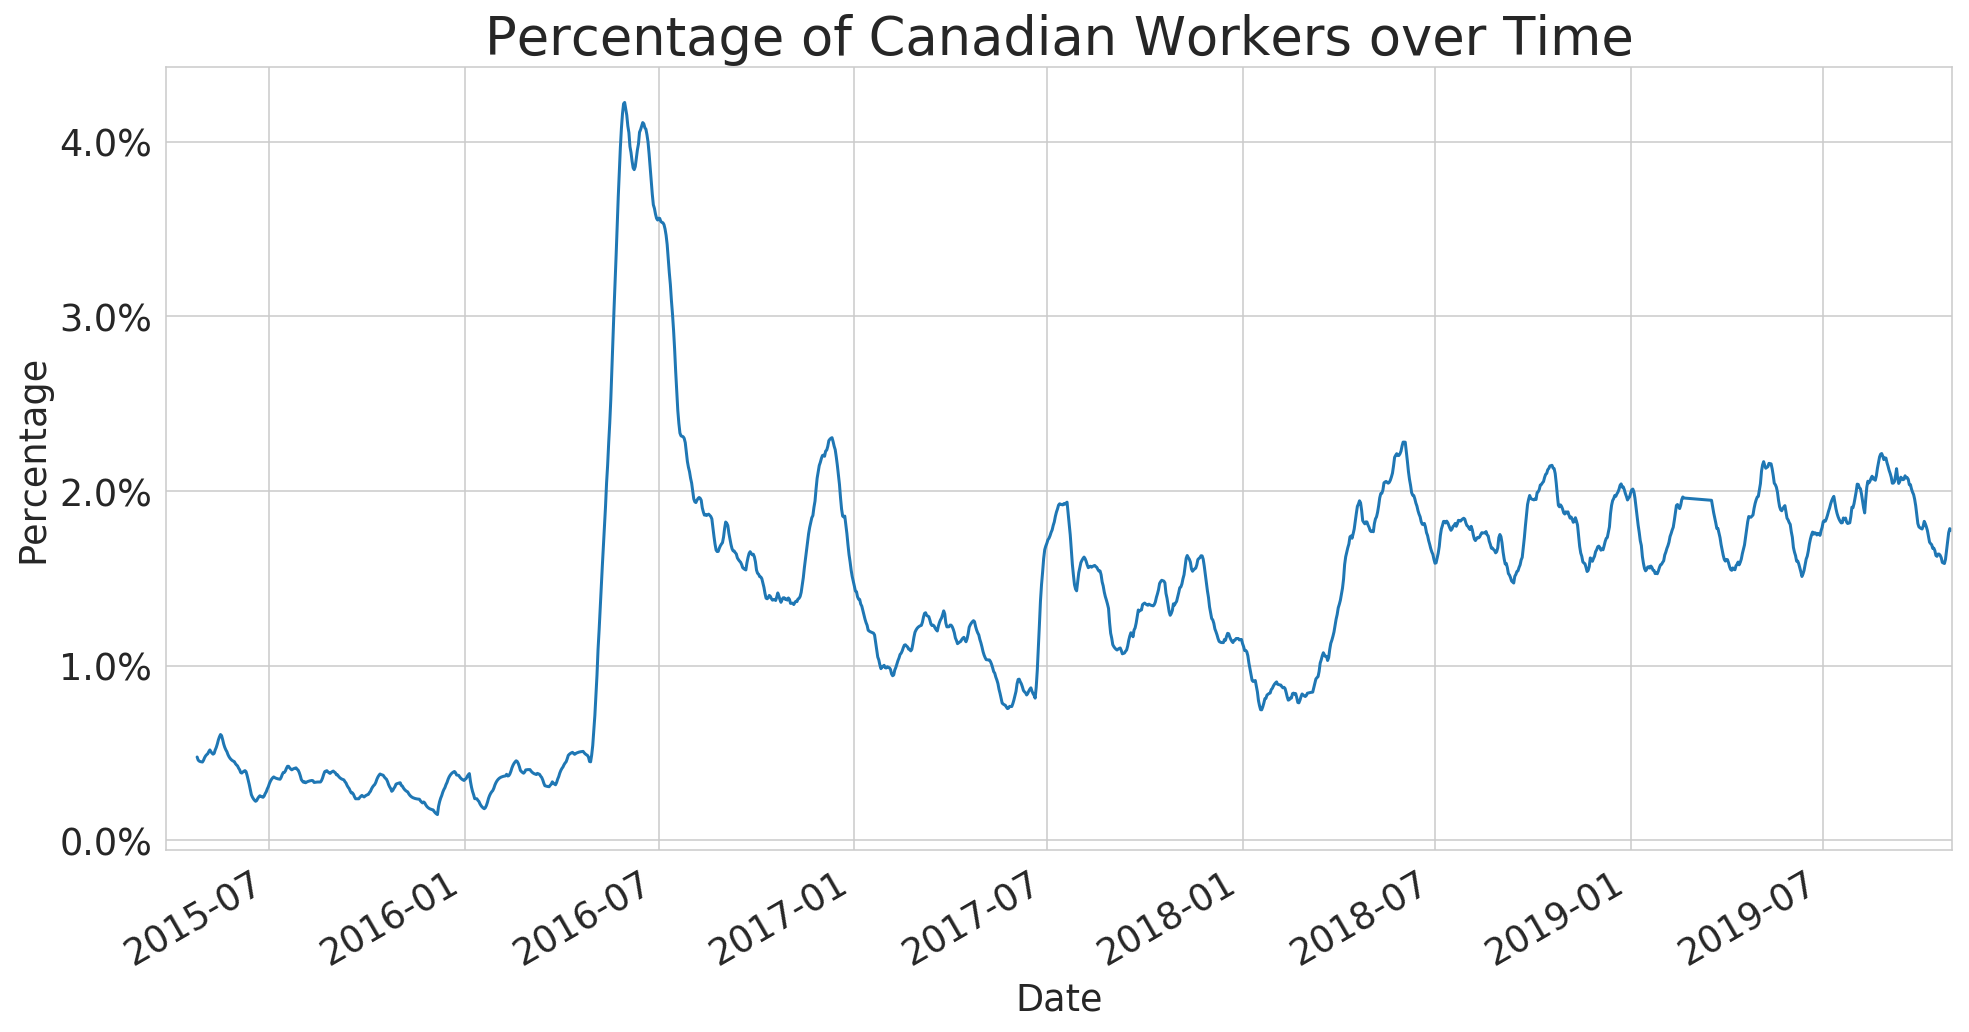

In [26]:
time_plot(100*country_table['CA'], 'Percentage of Canadian Workers over Time', 'plots/country-ca.pdf', confidence=False)


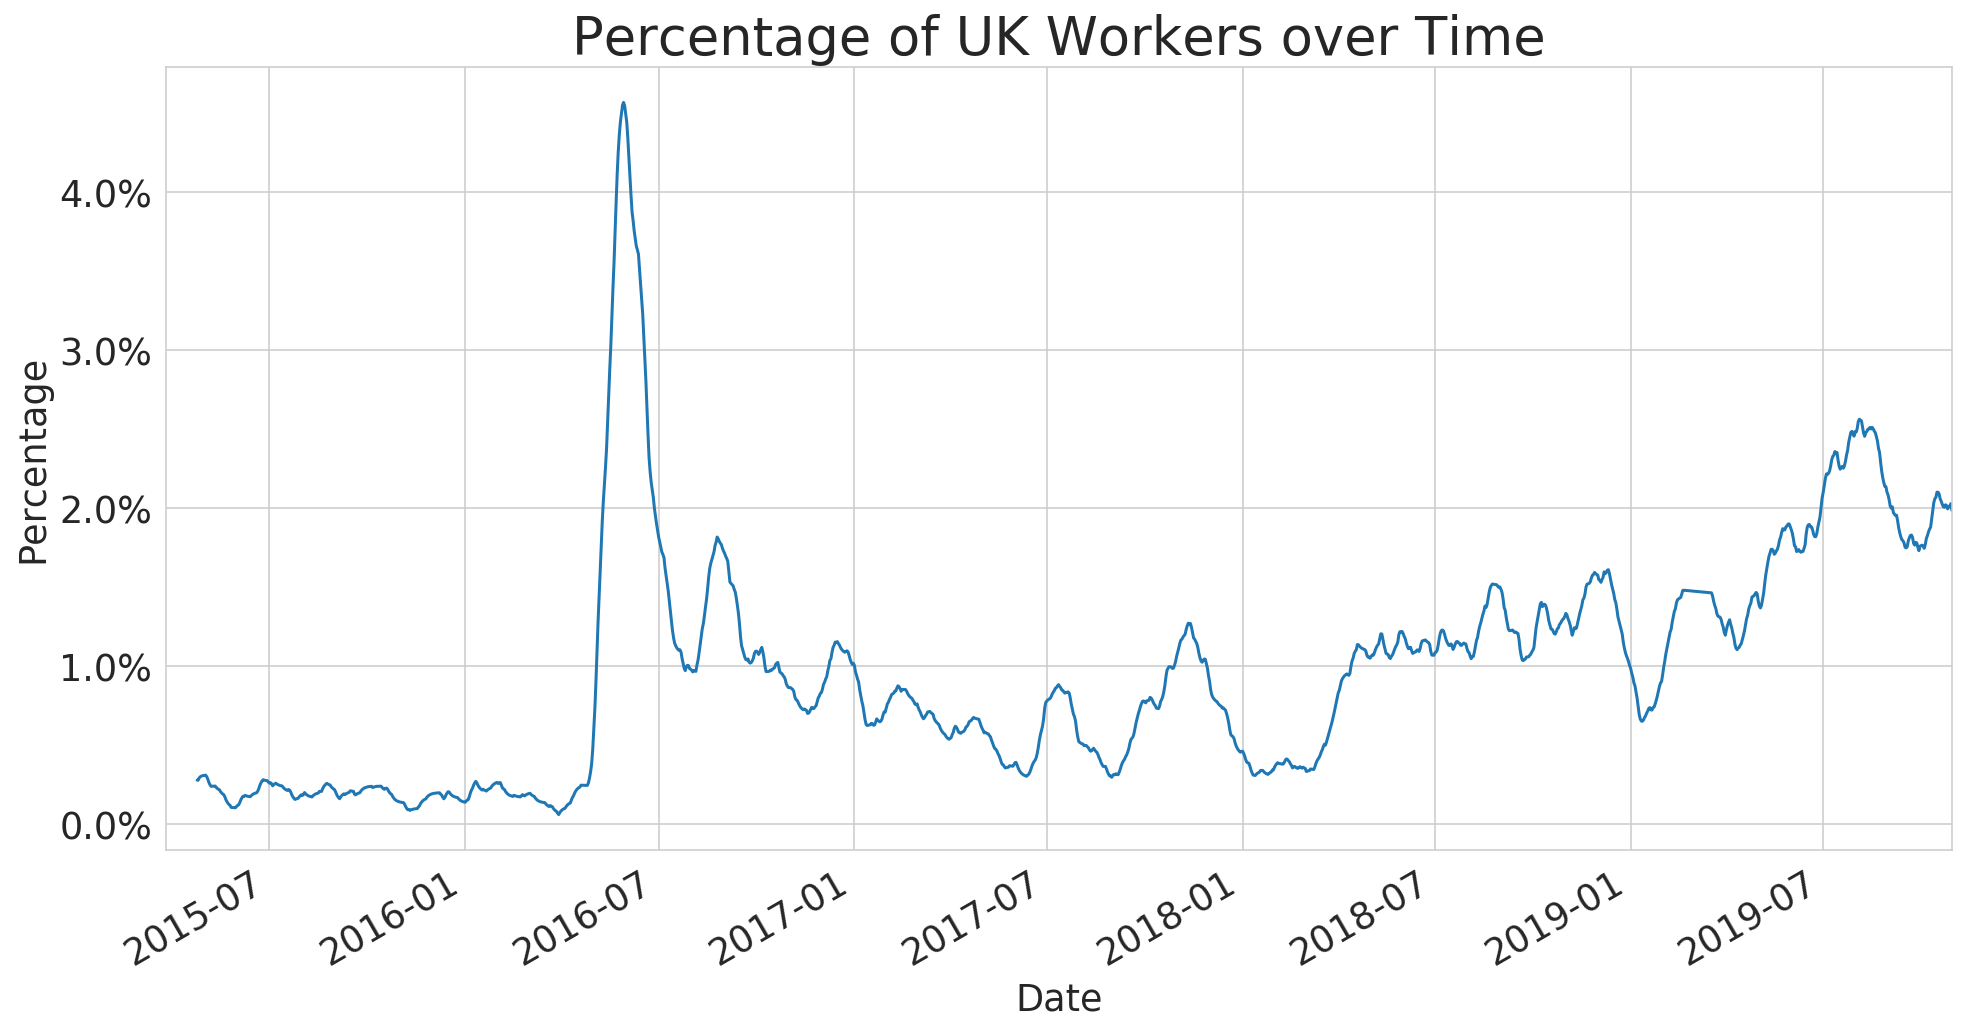

In [27]:

time_plot(100*country_table['GB'], 'Percentage of UK Workers over Time', 'plots/country-gb.pdf', confidence=False)


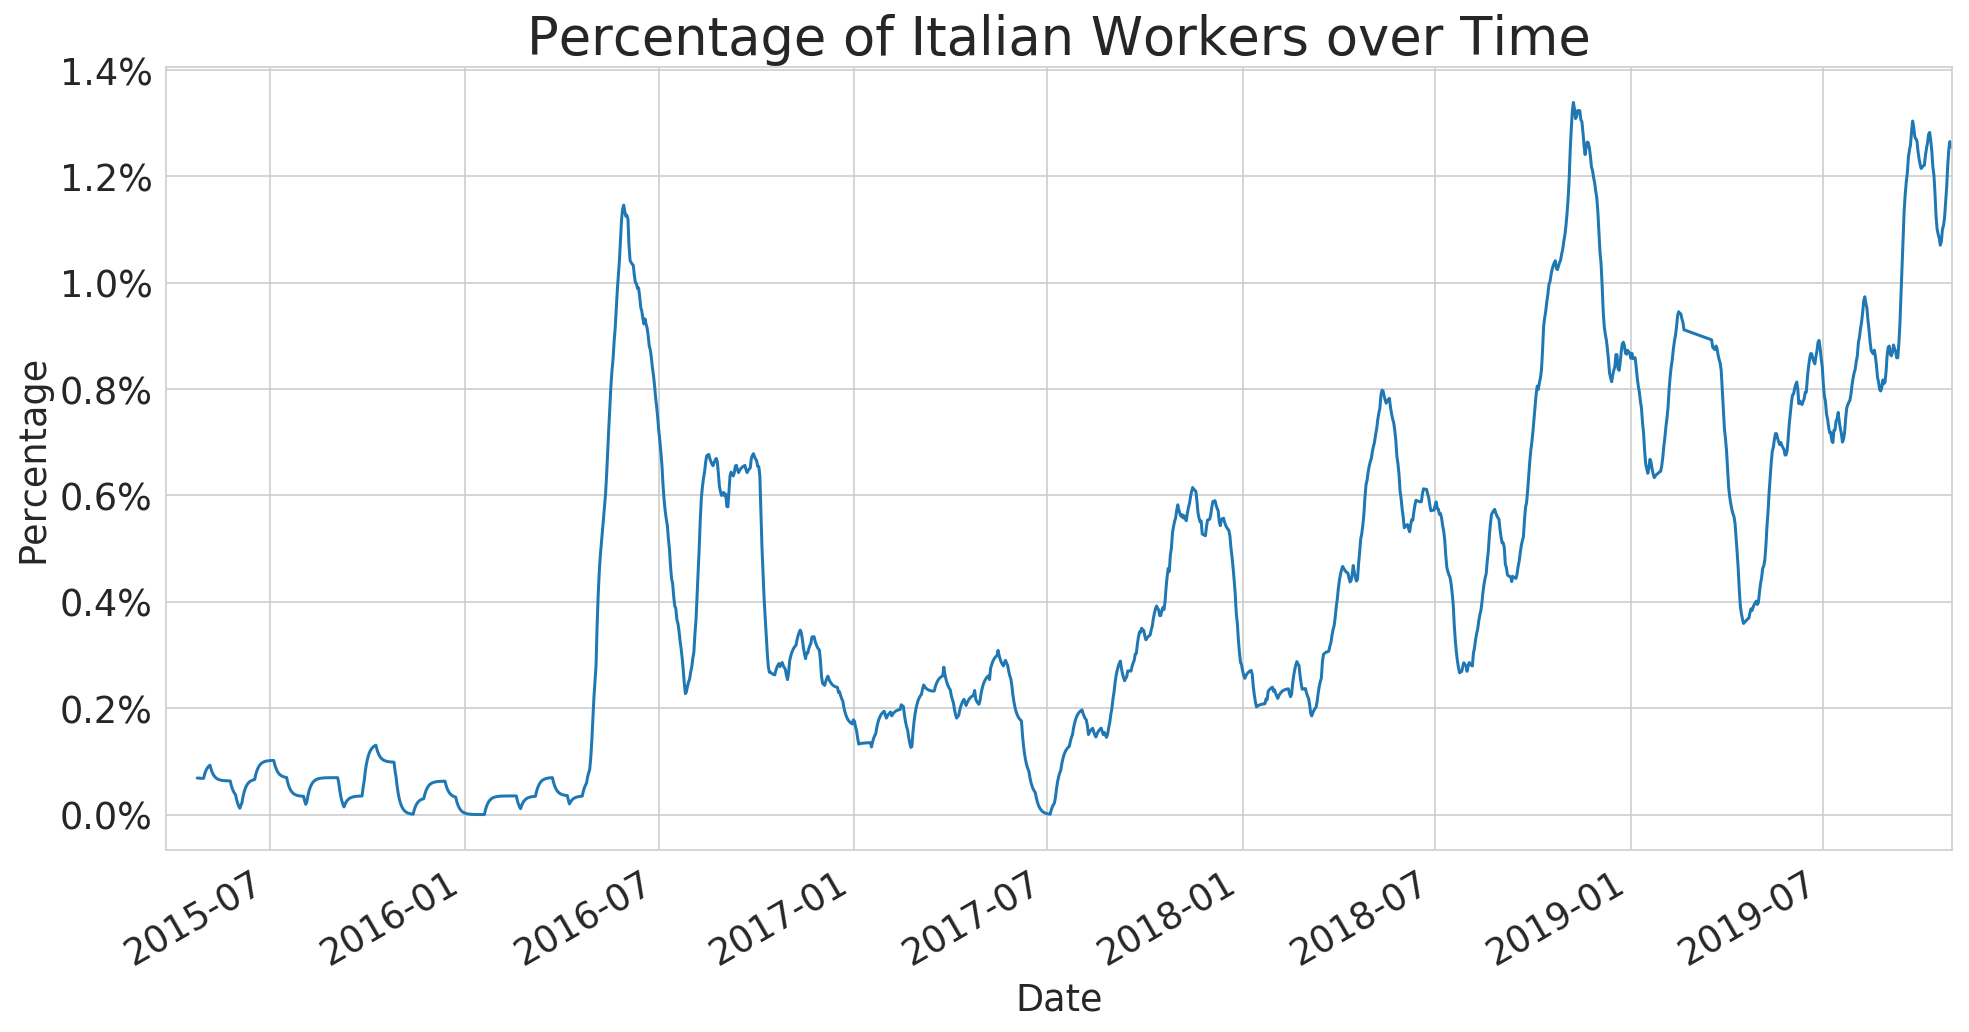

In [28]:
time_plot(100*country_table['IT'], 'Percentage of Italian Workers over Time', 'plots/country-it.pdf', confidence=False)


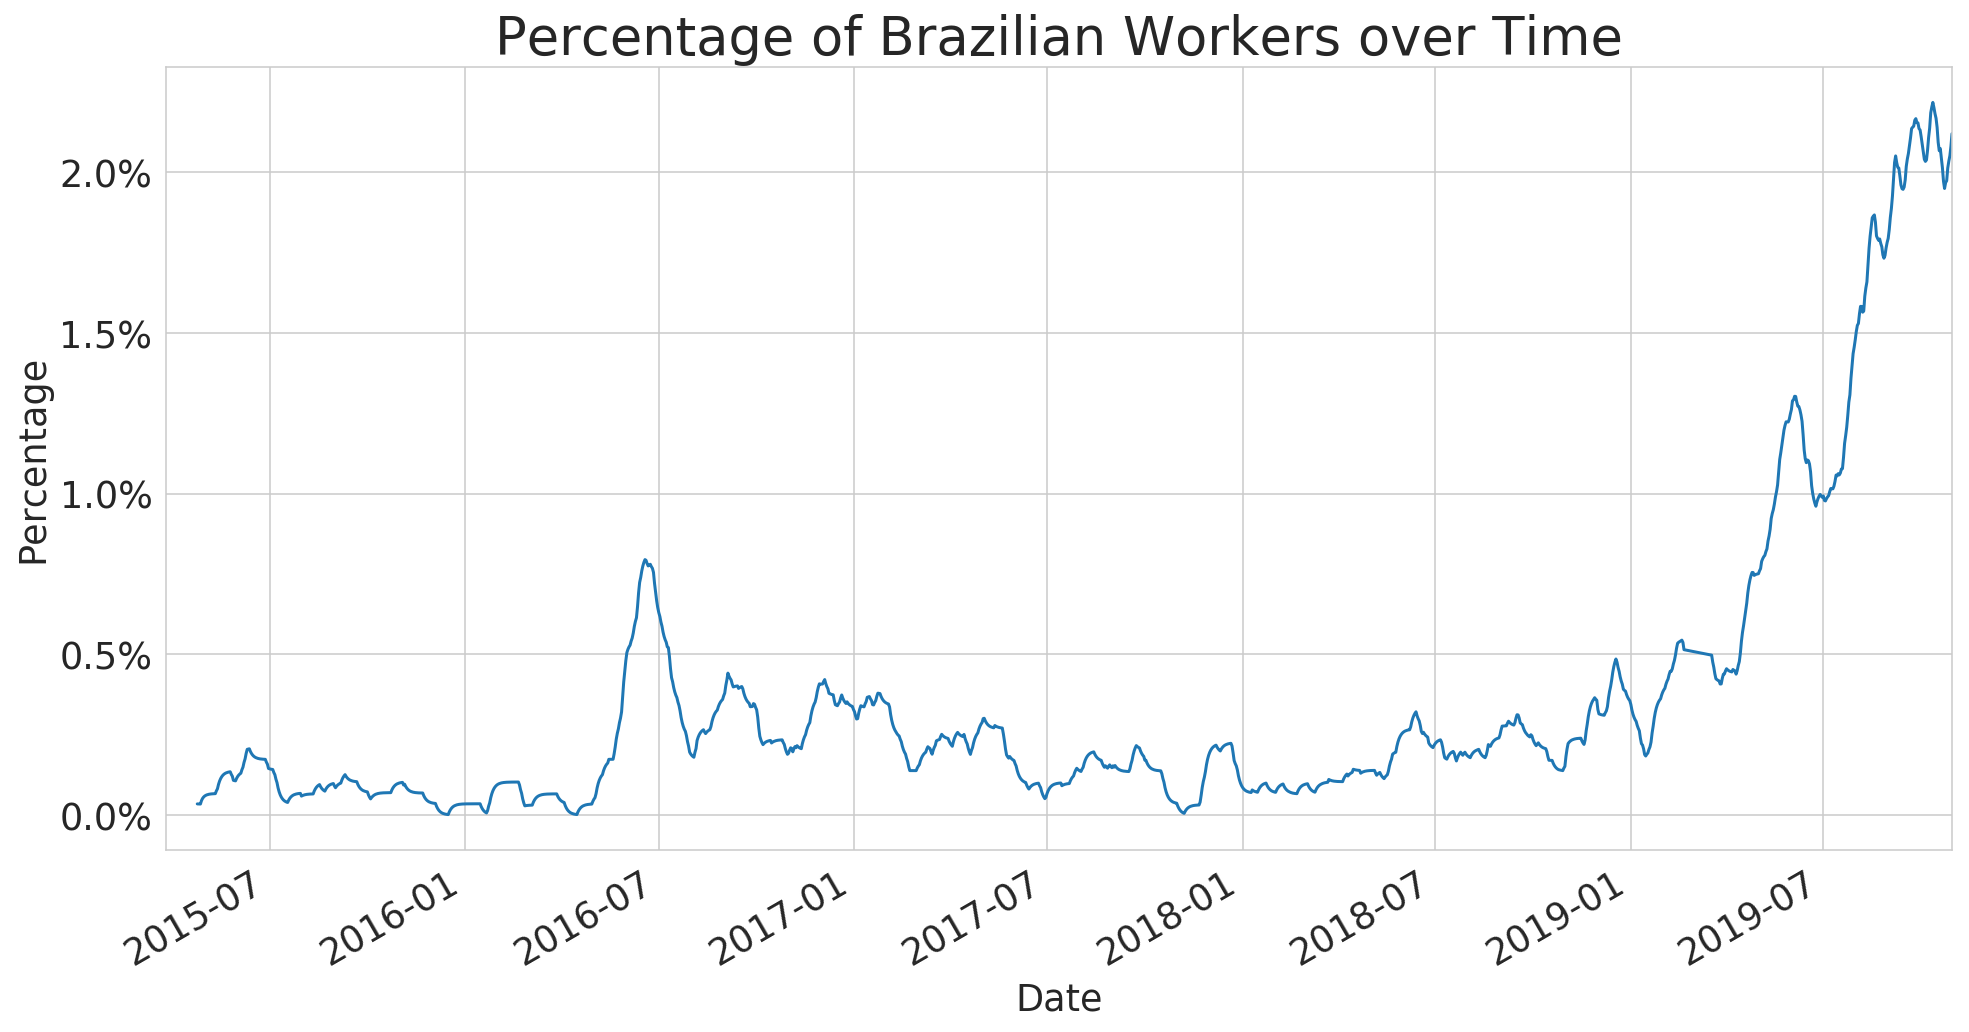

In [29]:

time_plot(100*country_table['BR'], 'Percentage of Brazilian Workers over Time', 'plots/country-br.pdf', confidence=False)


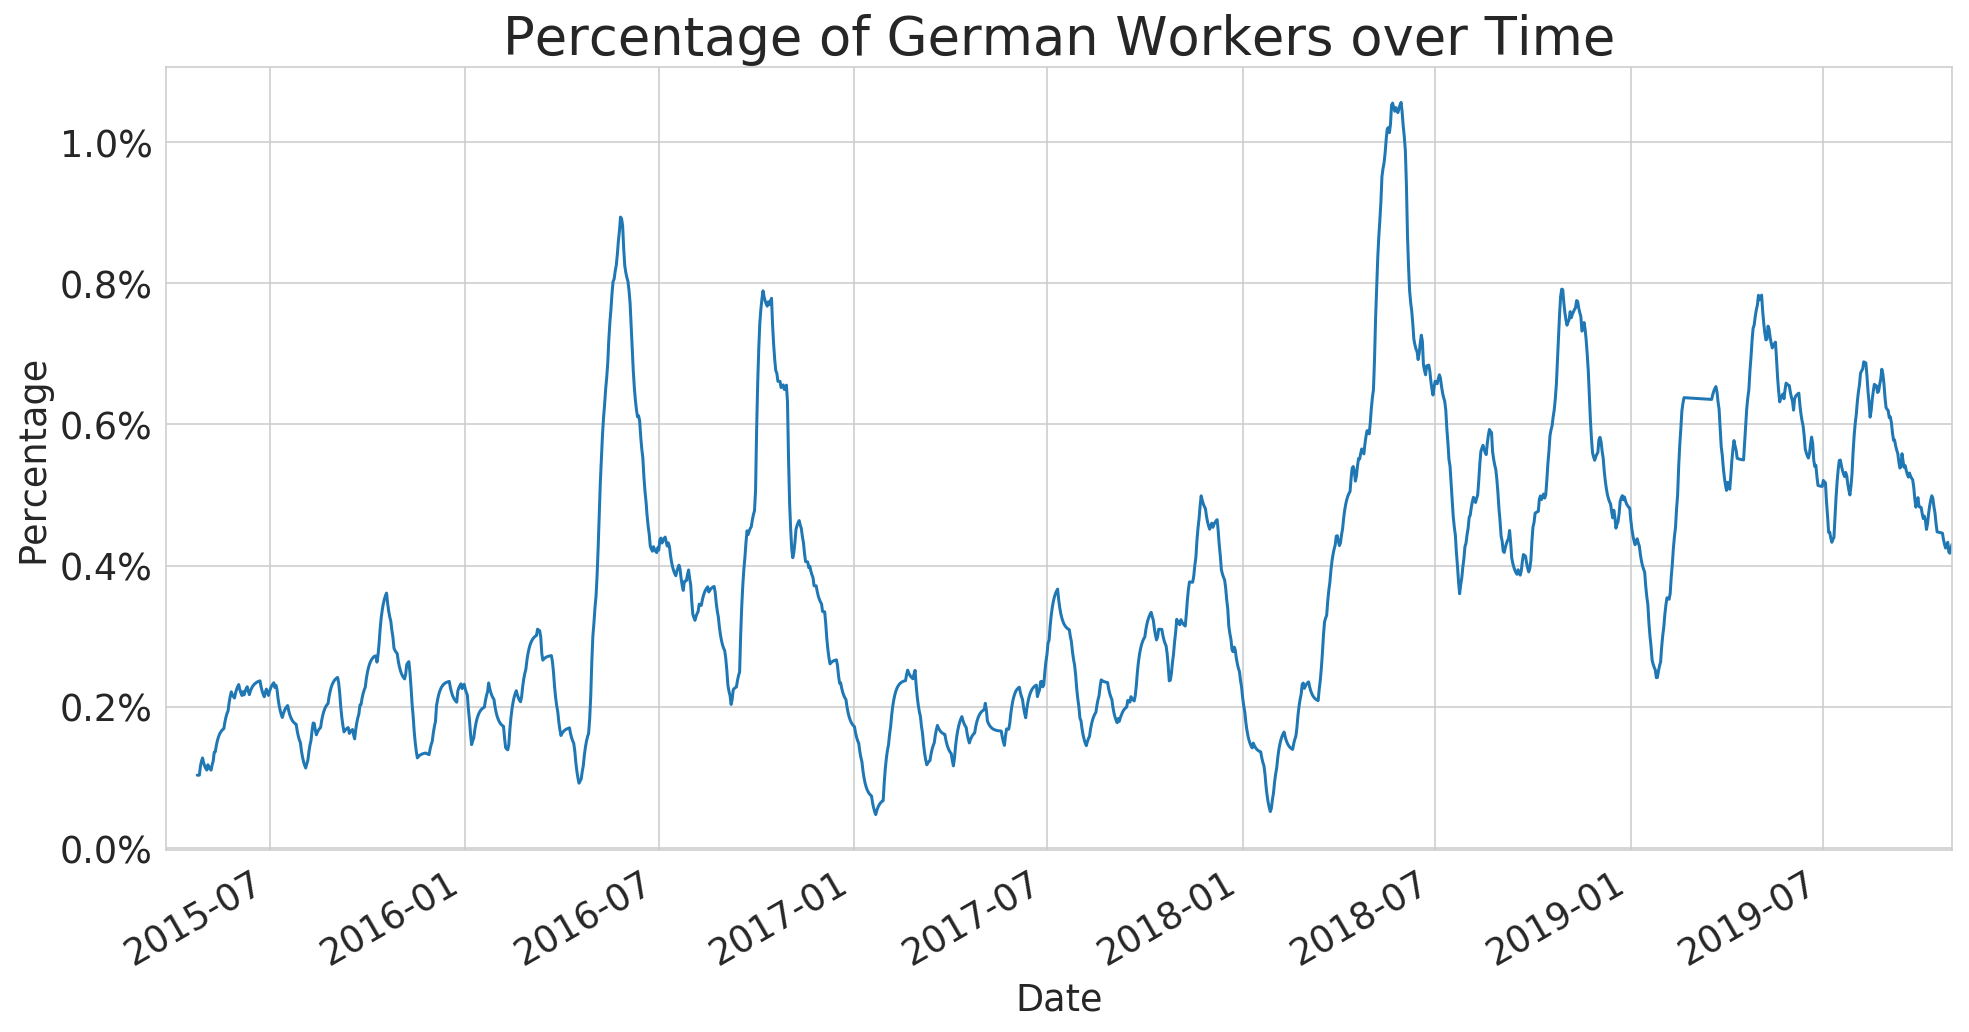

In [30]:
time_plot(100*country_table['DE'], 'Percentage of German Workers over Time', 'plots/country-de.pdf', confidence=False)

In [31]:
country_table_time = pd.crosstab(index=df.time, 
                                 columns=df.location_country, 
                                 values='worker_id', 
                                 aggfunc=np.count_nonzero, 
                                 normalize='index')
country_table_time.sort_index(inplace=True)

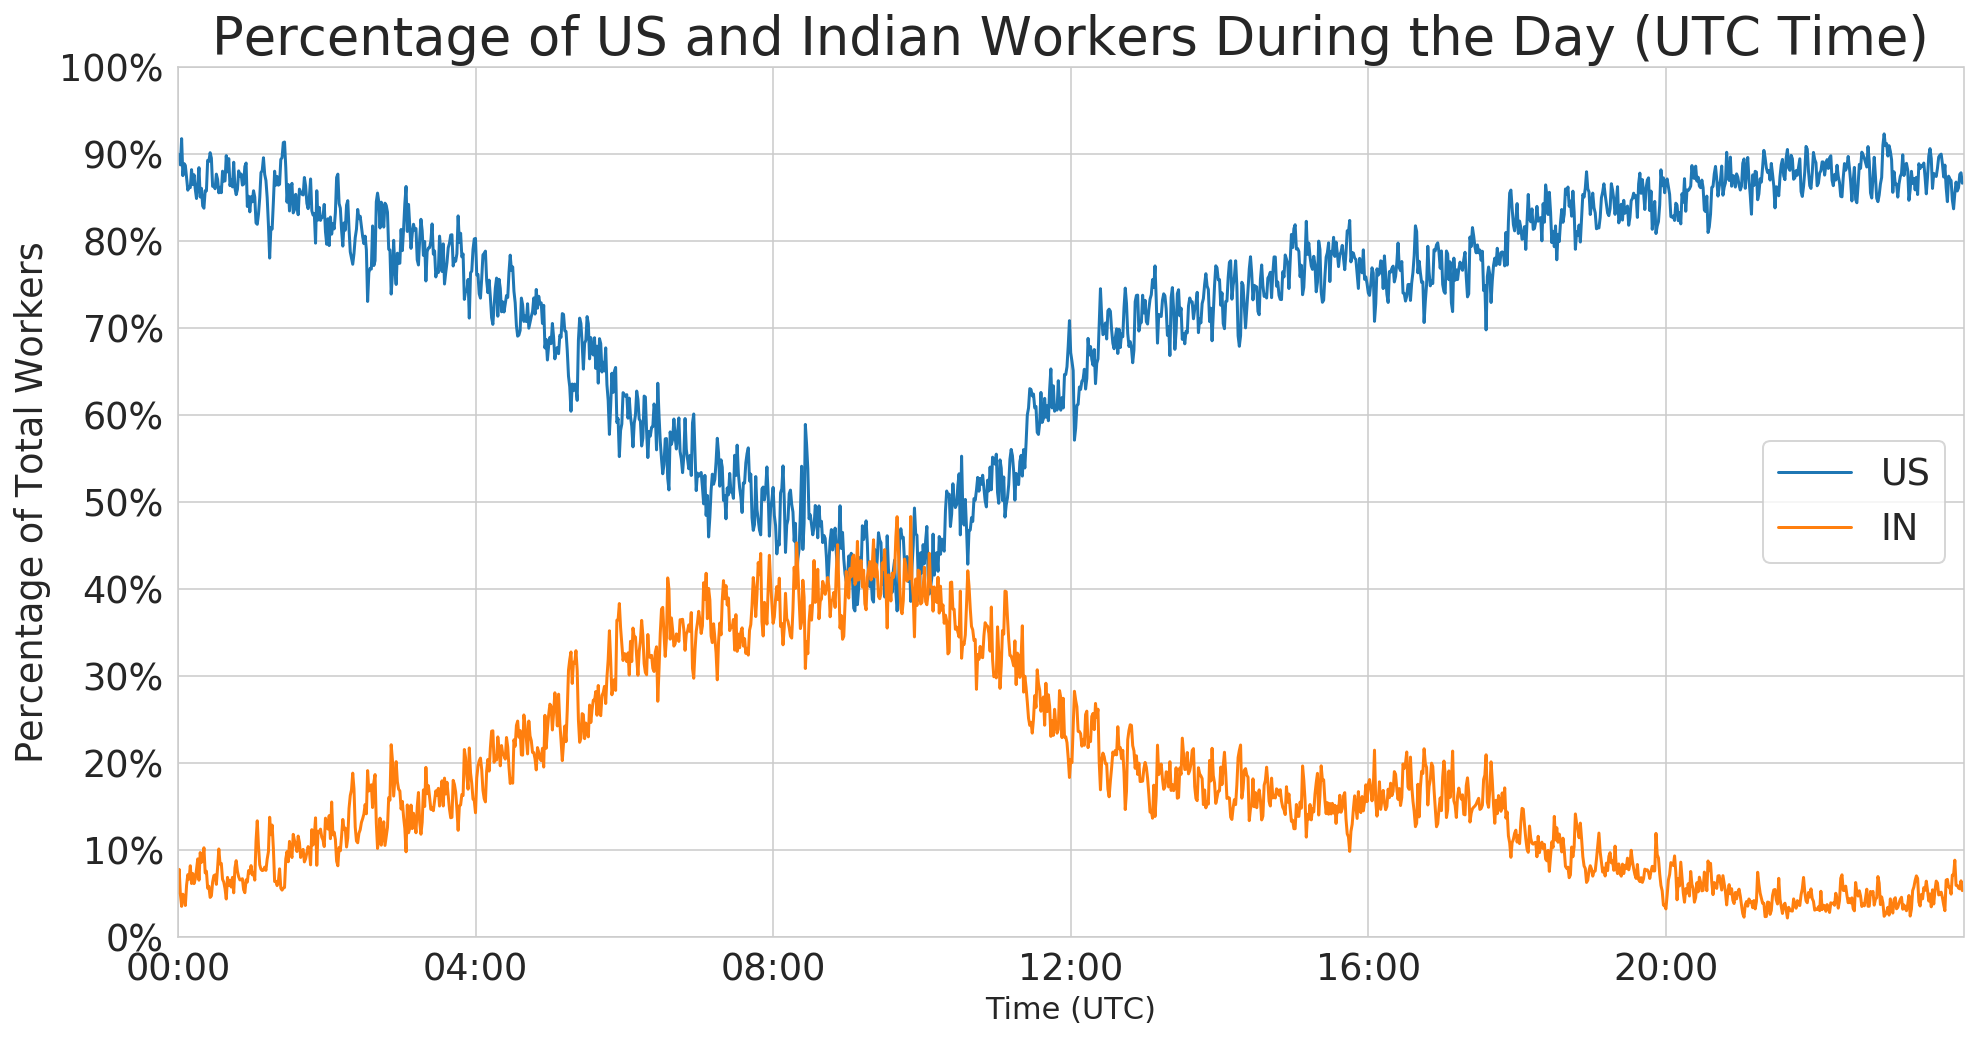

In [32]:
m = 100*country_table_time[['US','IN']].ewm(span=3).mean()

ax = m.plot( fontsize='small', xlim=[0,86400], ylim=[0,1])
ax.set_title("Percentage of US and Indian Workers During the Day (UTC Time)", fontsize='large')
ax.set_ylabel("Percentage of Total Workers", fontsize='small')
ax.set_xlabel("Time (UTC)", fontsize='x-small')
ax.xaxis.set_ticks(np.arange(0, 84400, 14400))
ax.yaxis.set_ticks(np.arange(0, 110, 10))
fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
yticks = mtick.FormatStrFormatter(fmt)
ax.yaxis.set_major_formatter(yticks)
    
ax.legend( fontsize='small')
fig = ax.get_figure()
fig.savefig('plots/country-usa-india-time-of-day.pdf', bbox_inches='tight')

In [33]:
# No significant periodicity
# from pandas.plotting import autocorrelation_plot
# data = country_table['US'].ewm(span=1).mean().diff()[1:]
# autocorrelation_plot(data)

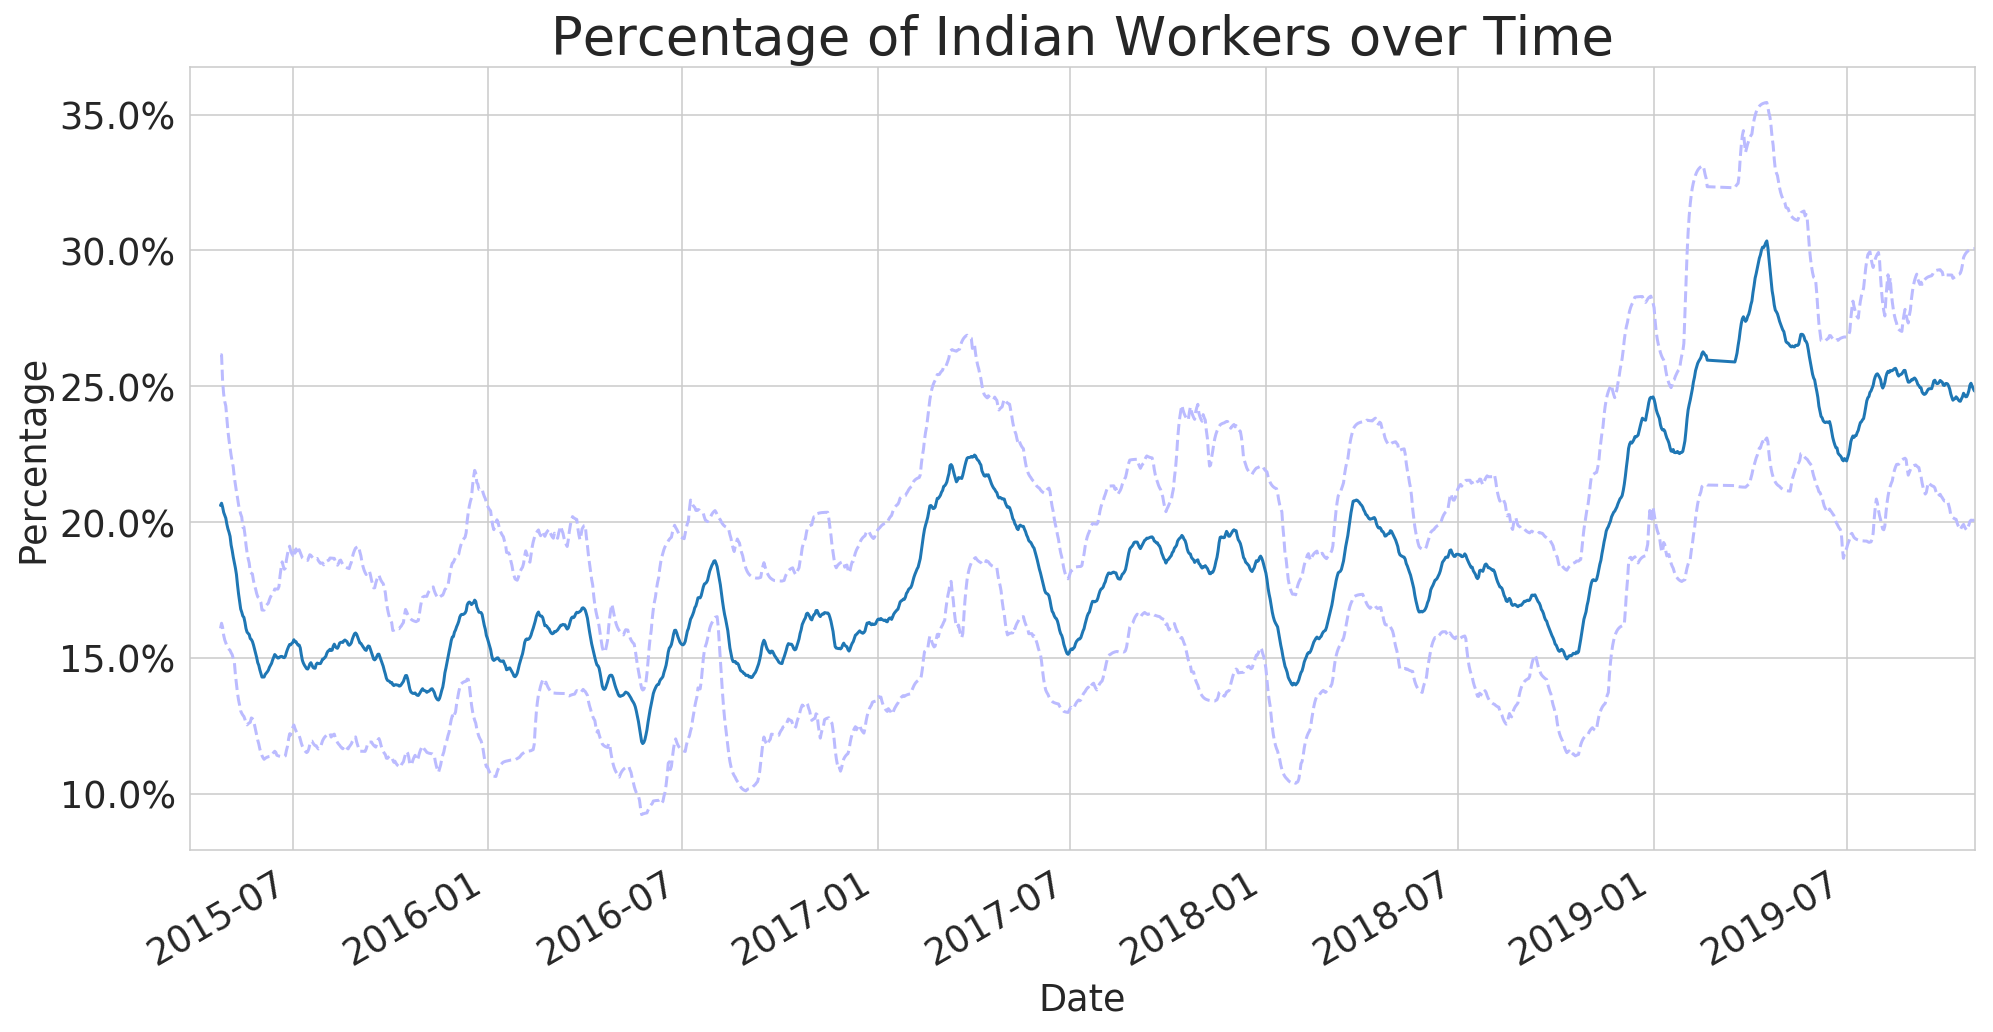

In [34]:
time_plot(100*country_table['IN'], 
          'Percentage of Indian Workers over Time', 
          'plots/country-india.pdf')

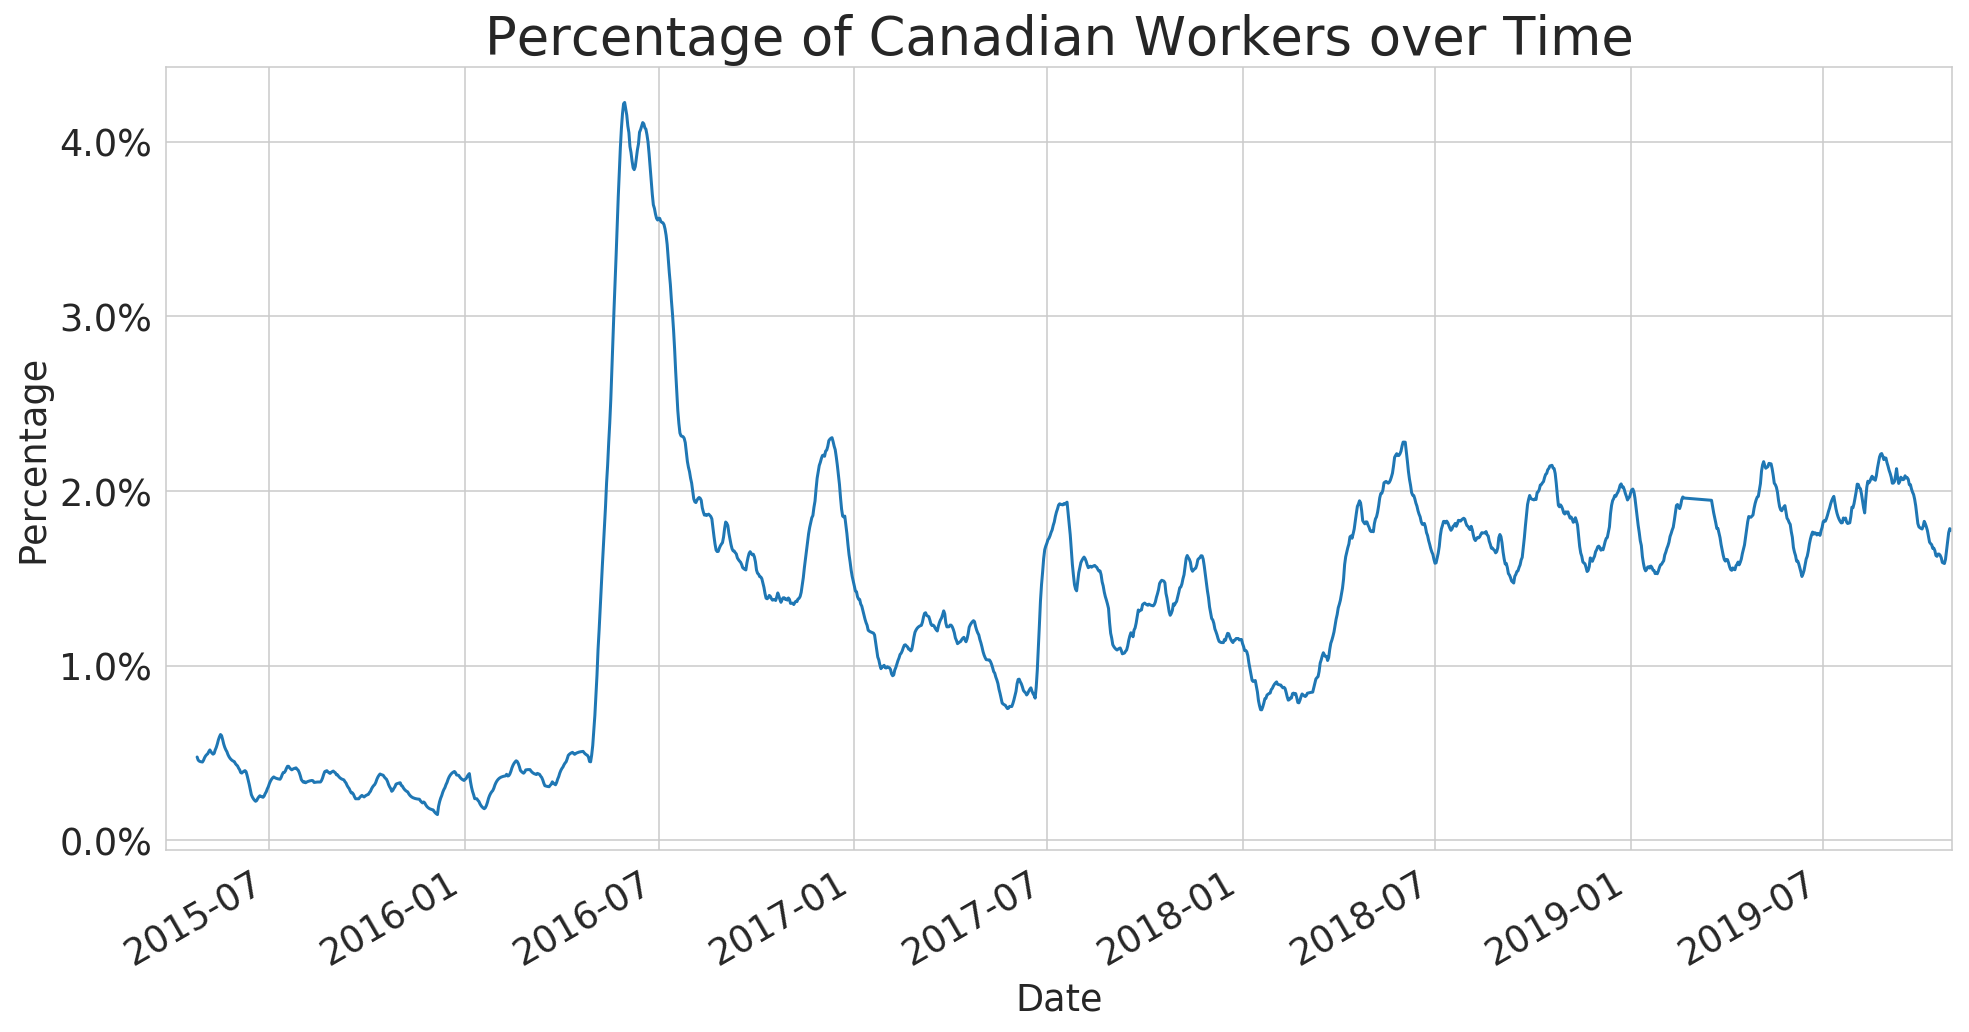

In [35]:
time_plot(data = 100*country_table['CA'], 
          title = 'Percentage of Canadian Workers over Time', 
          filename = 'plots/country-canada.pdf', 
          confidence=False)

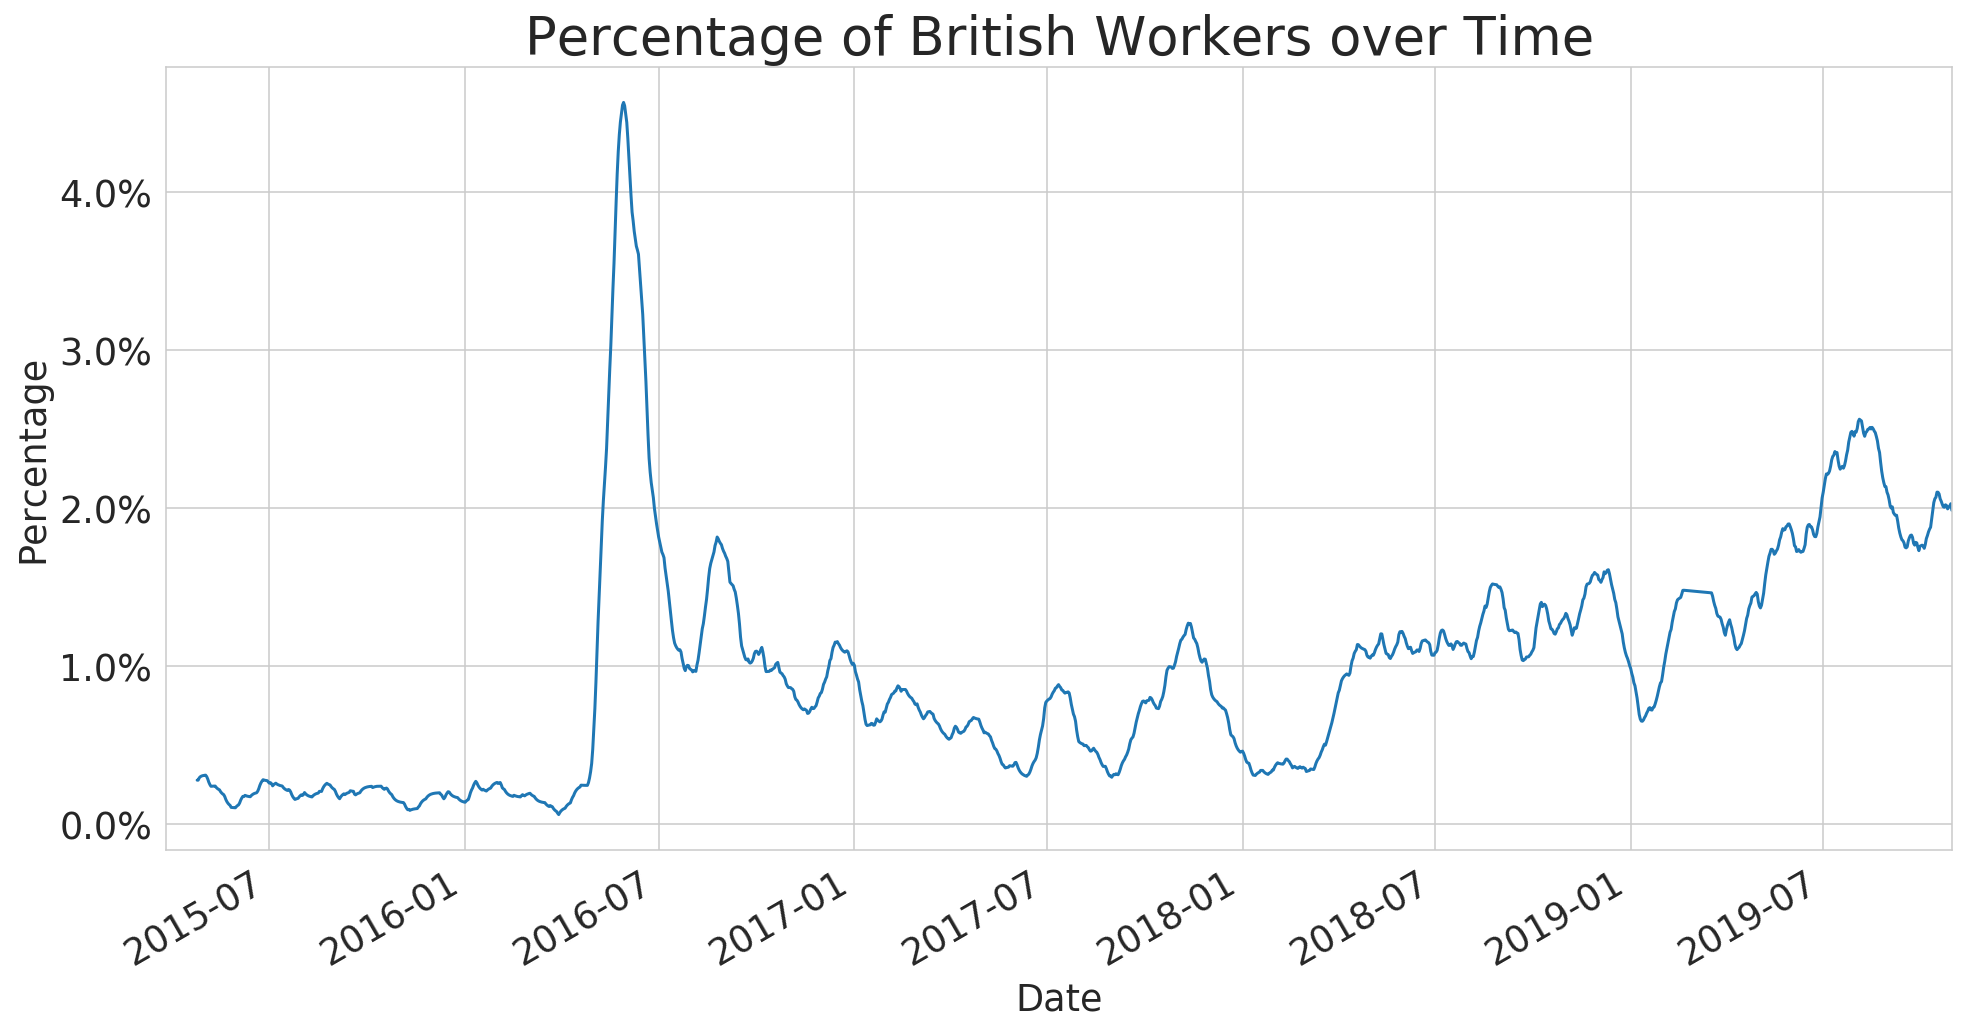

In [36]:
time_plot(data = 100*country_table['GB'], 
          title = 'Percentage of British Workers over Time', 
          filename = 'plots/country-uk.pdf', 
          confidence=False)

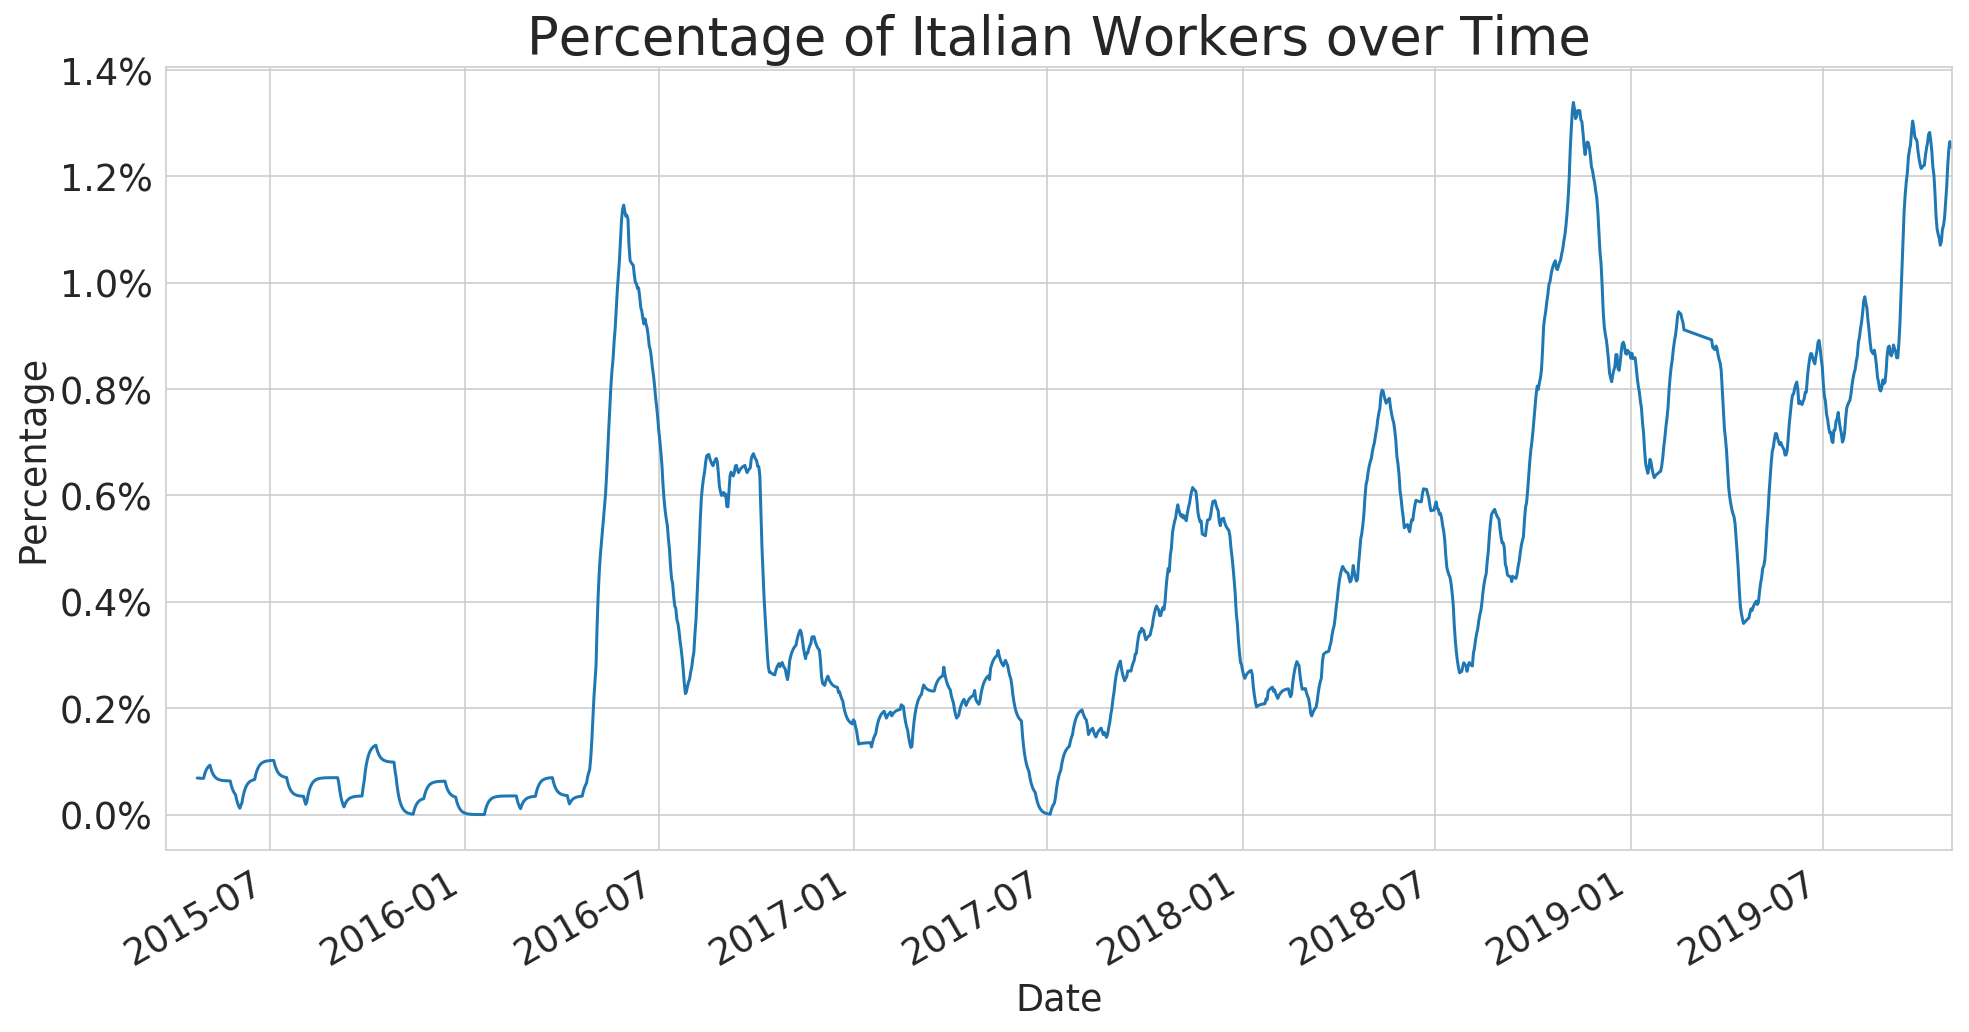

In [37]:
time_plot(100*country_table['IT'], 
          'Percentage of Italian Workers over Time', 
          'plots/country-italy.pdf',
          confidence=False)

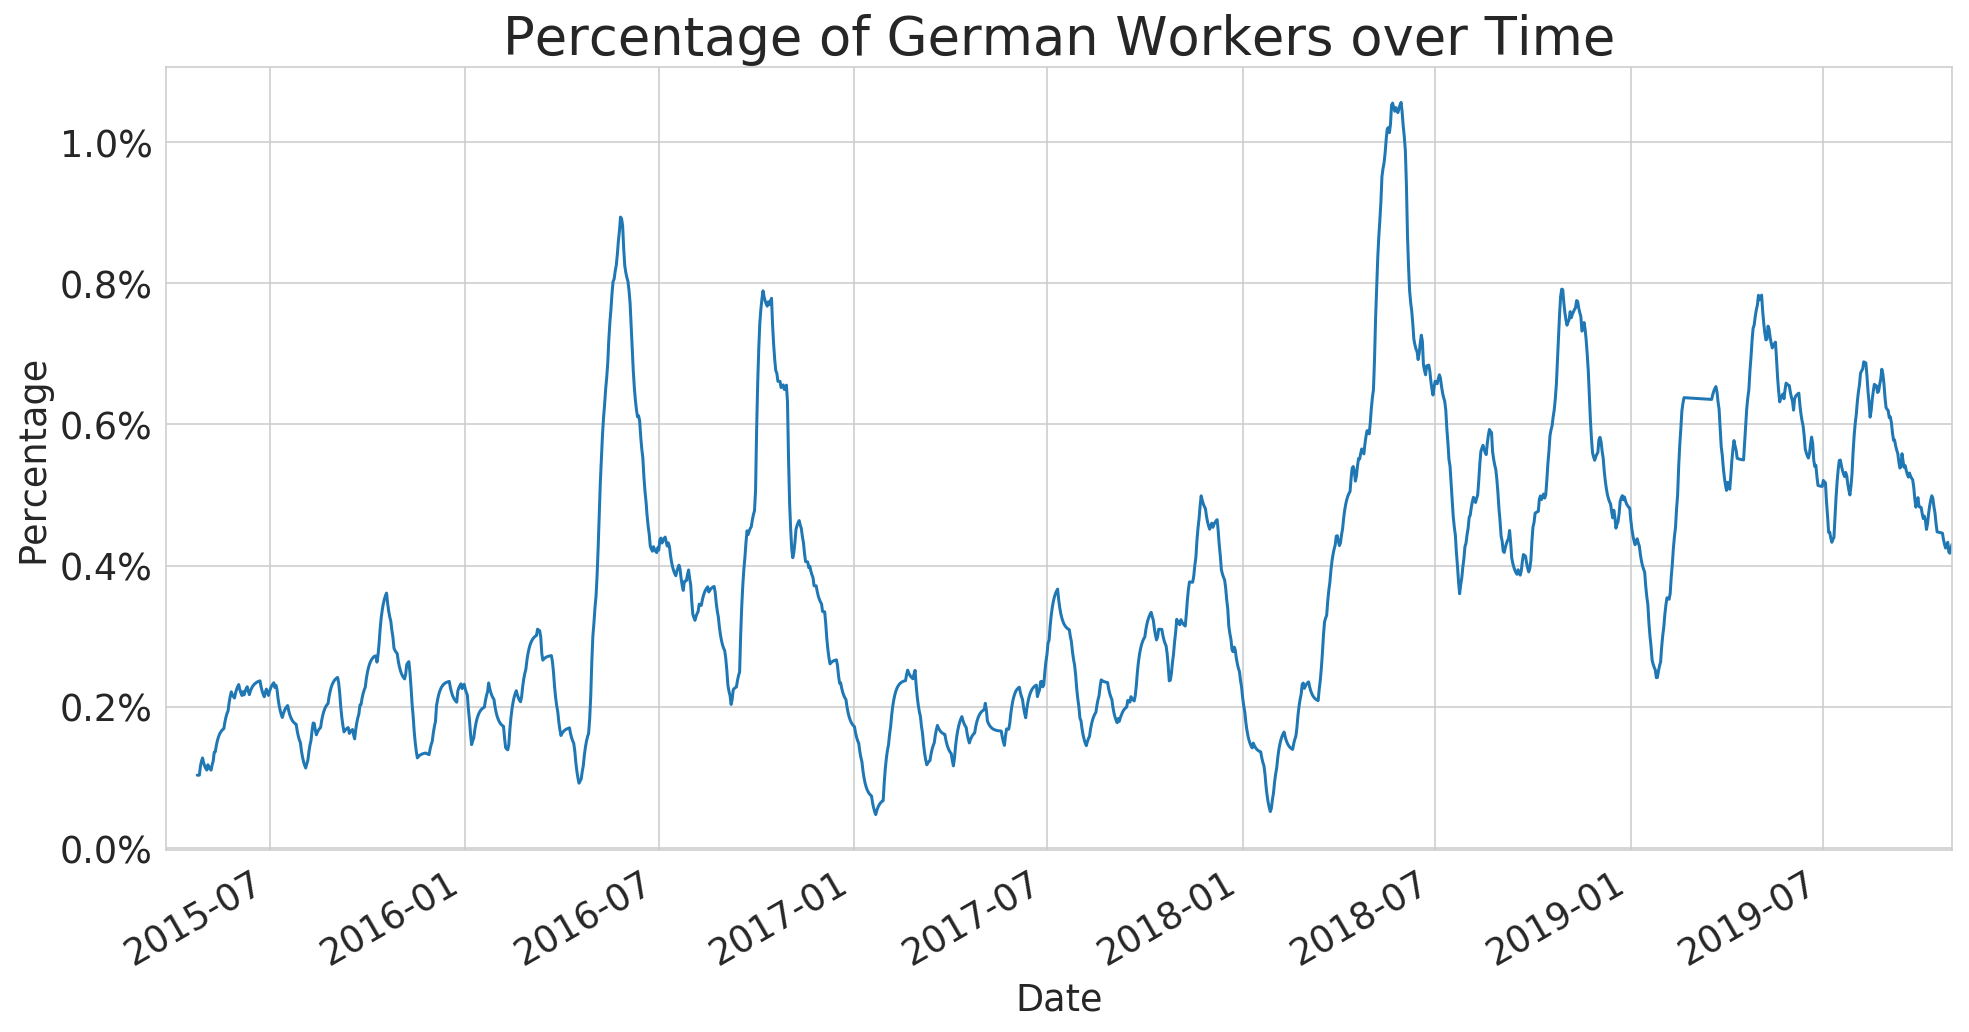

In [38]:
time_plot(100*country_table['DE'], 
          'Percentage of German Workers over Time', 
          'plots/country-germany.pdf',
          confidence=False)

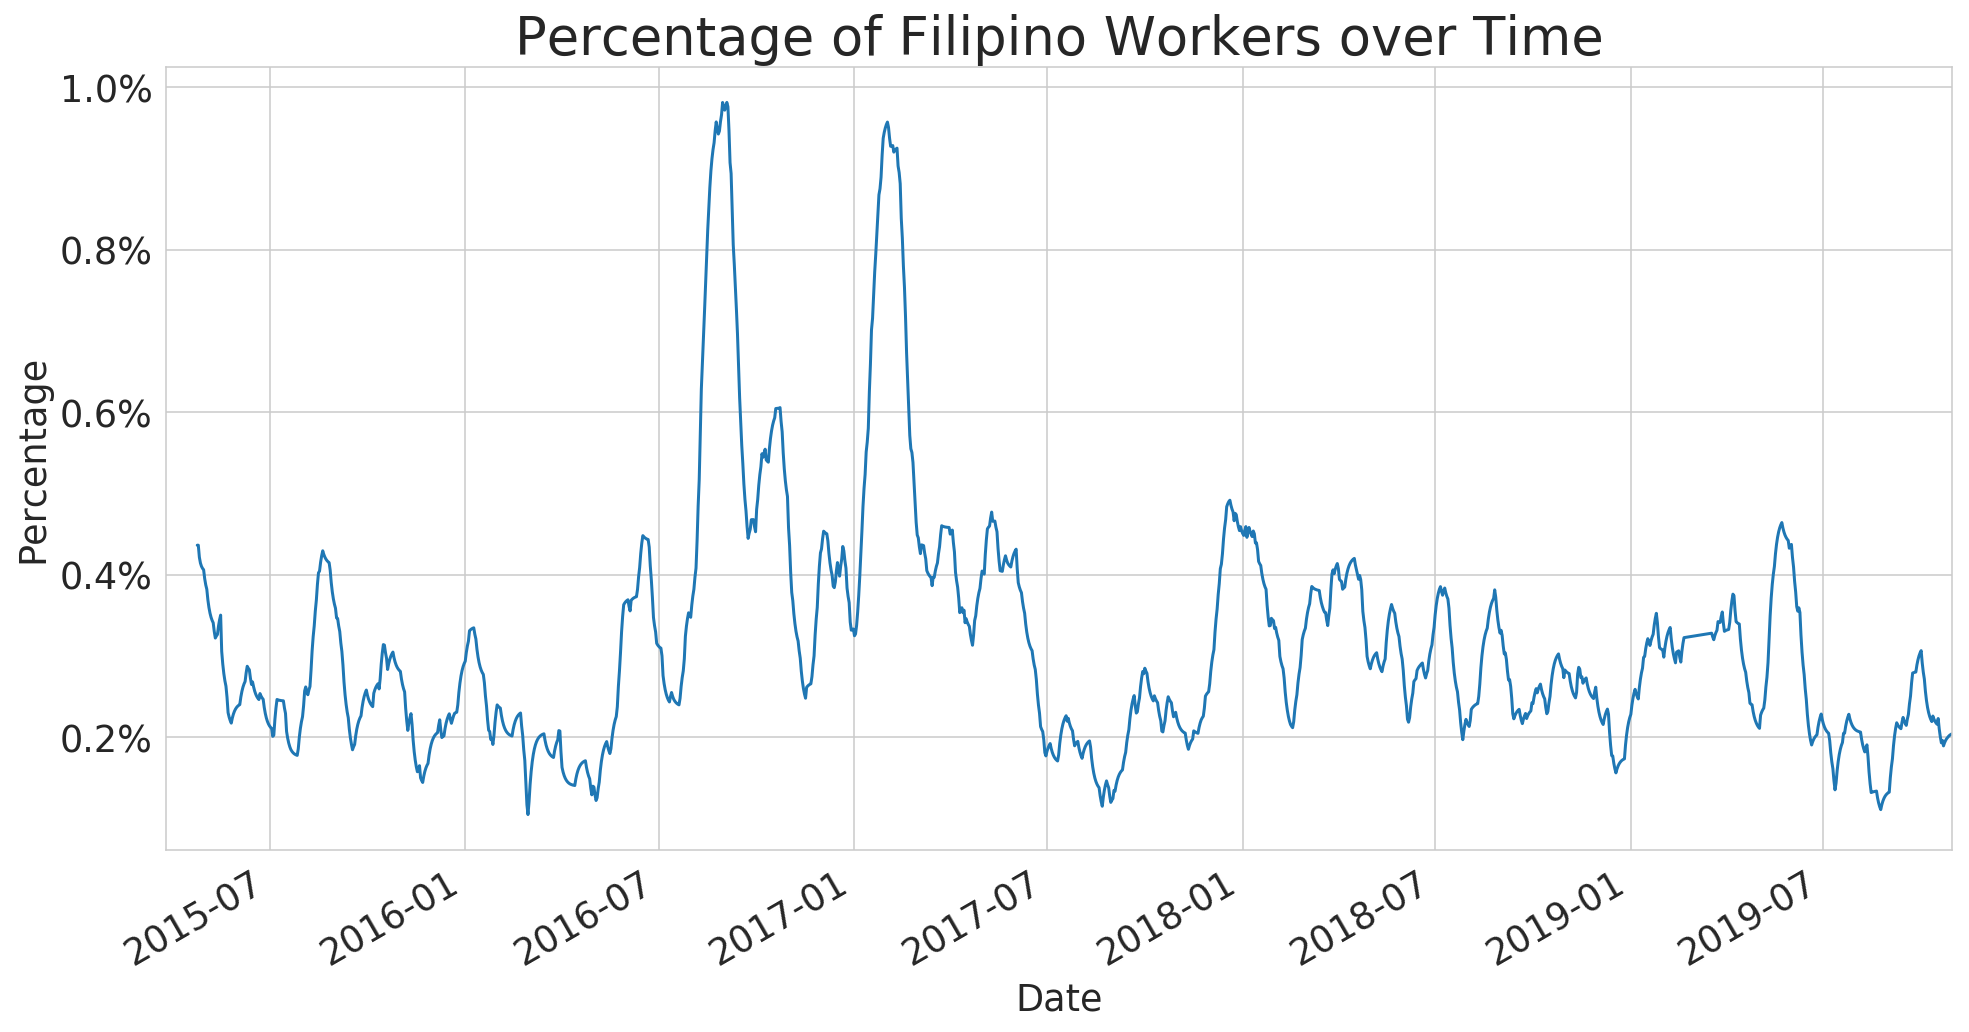

In [39]:
time_plot(100*country_table['PH'], 
          'Percentage of Filipino Workers over Time', 
          'plots/country-philipines.pdf',
          confidence=False)

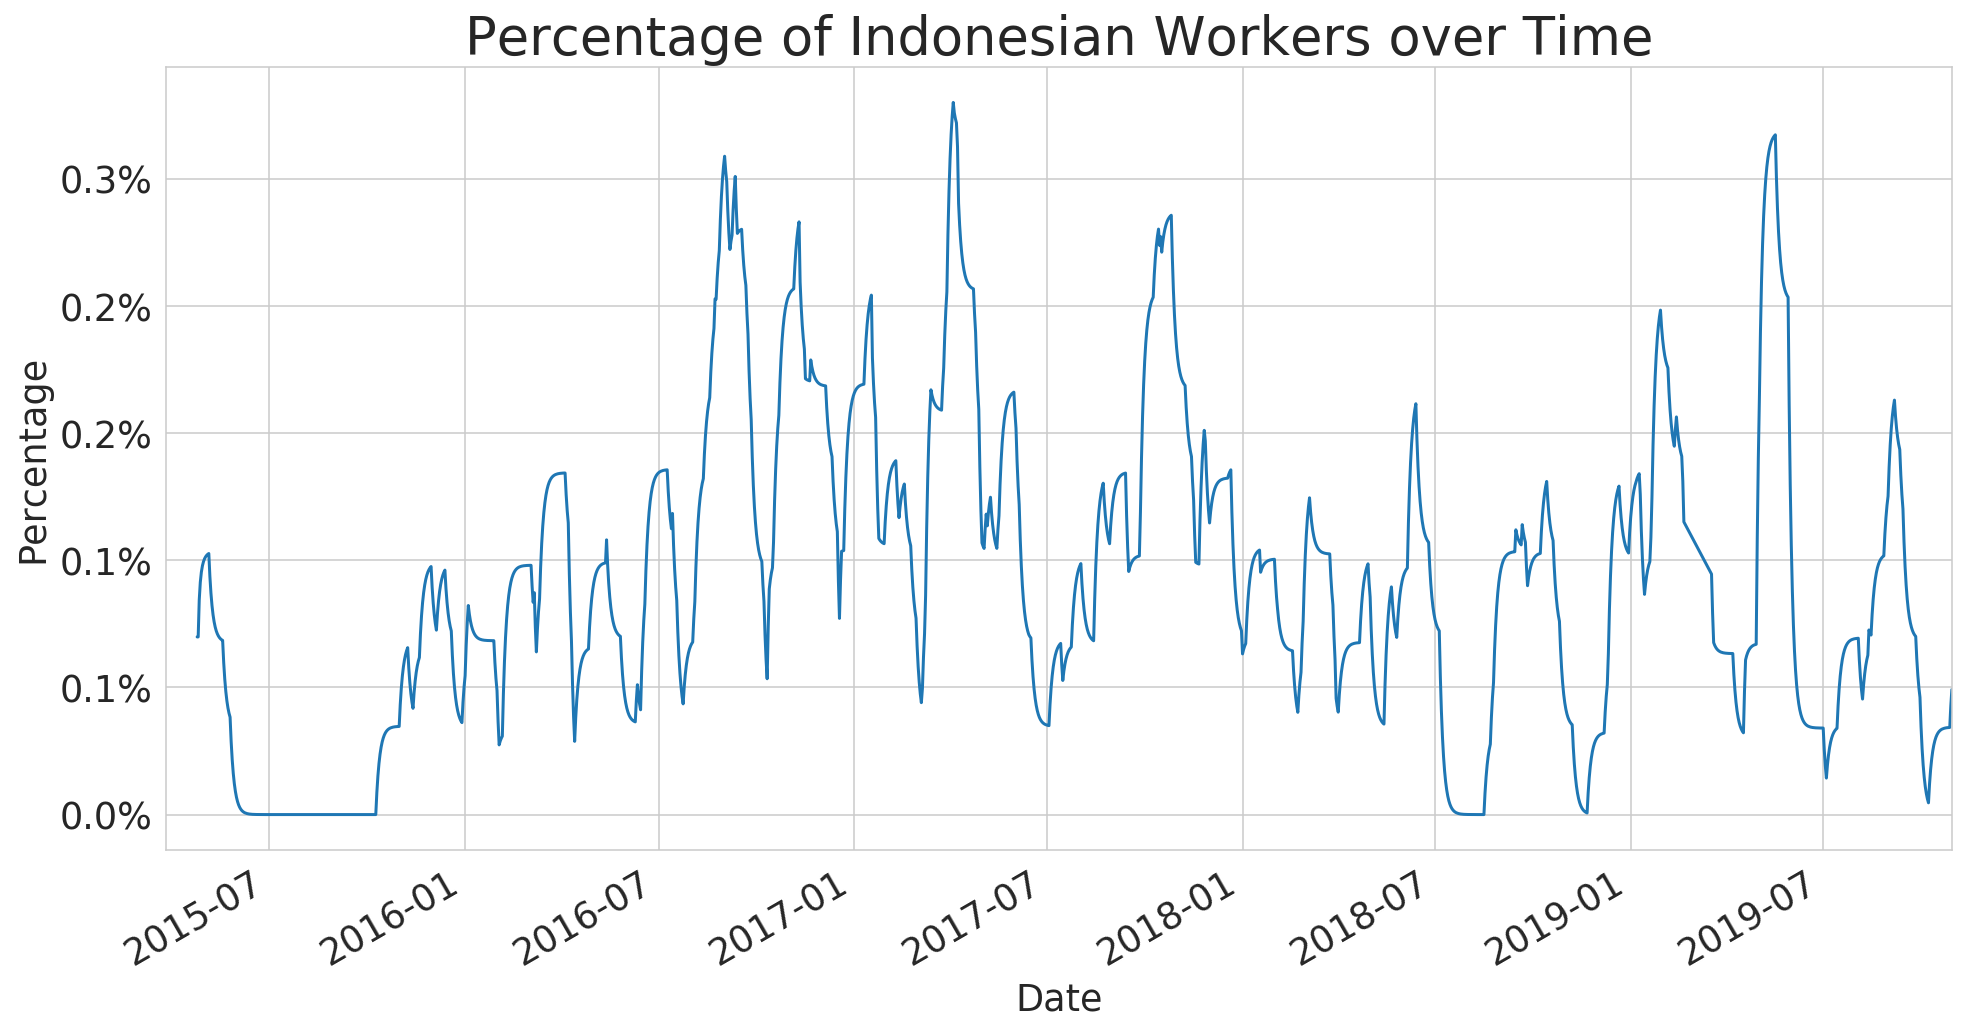

In [40]:
time_plot(100*country_table['ID'], 
          'Percentage of Indonesian Workers over Time', 
          'plots/country-indonesia.pdf',
          confidence=False)

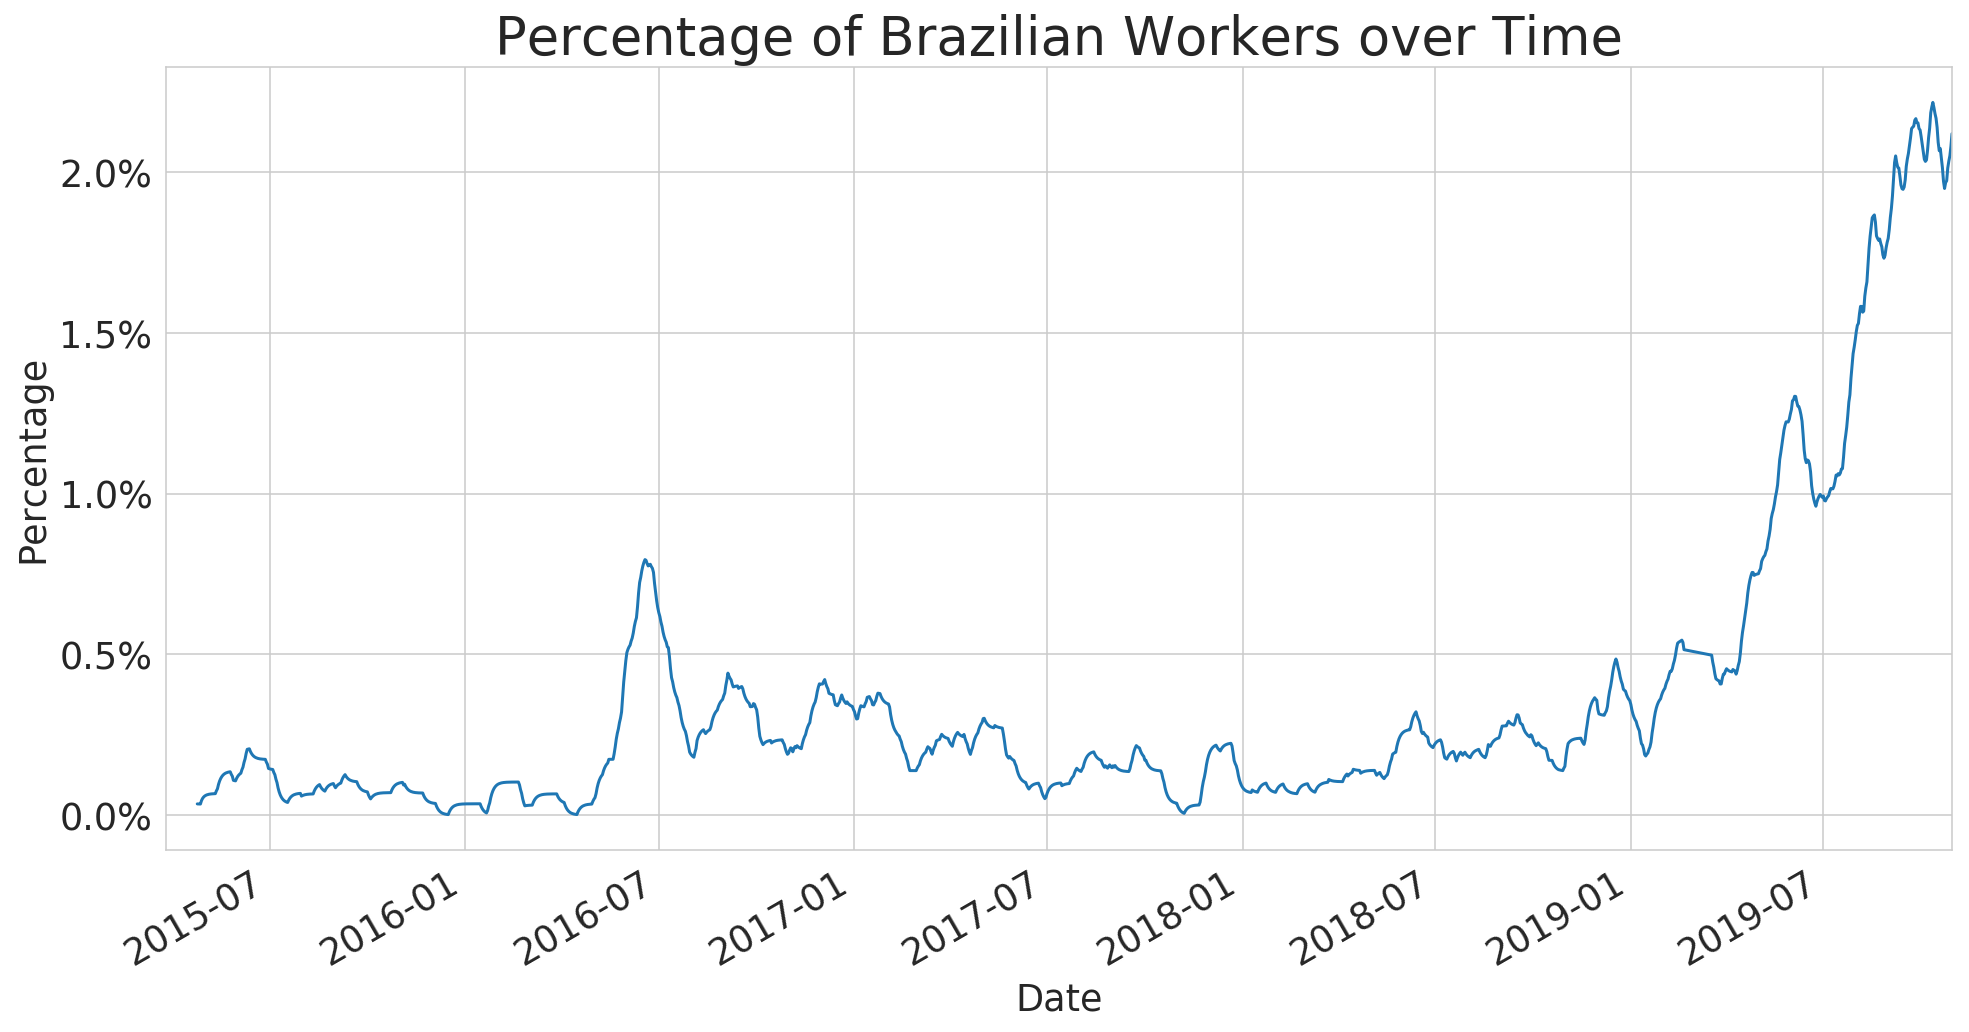

In [41]:
time_plot(100*country_table['BR'], 
          'Percentage of Brazilian Workers over Time', 
          'plots/country-brazil.pdf',
          confidence=False)

## Gender

In [42]:
gender_table = pd.crosstab(index=df.date, columns=df.gender, 
                            values='worker_id', aggfunc=np.count_nonzero, normalize='index')

In [43]:
gender_table.mean()

gender
female    0.487372
male      0.512628
dtype: float64

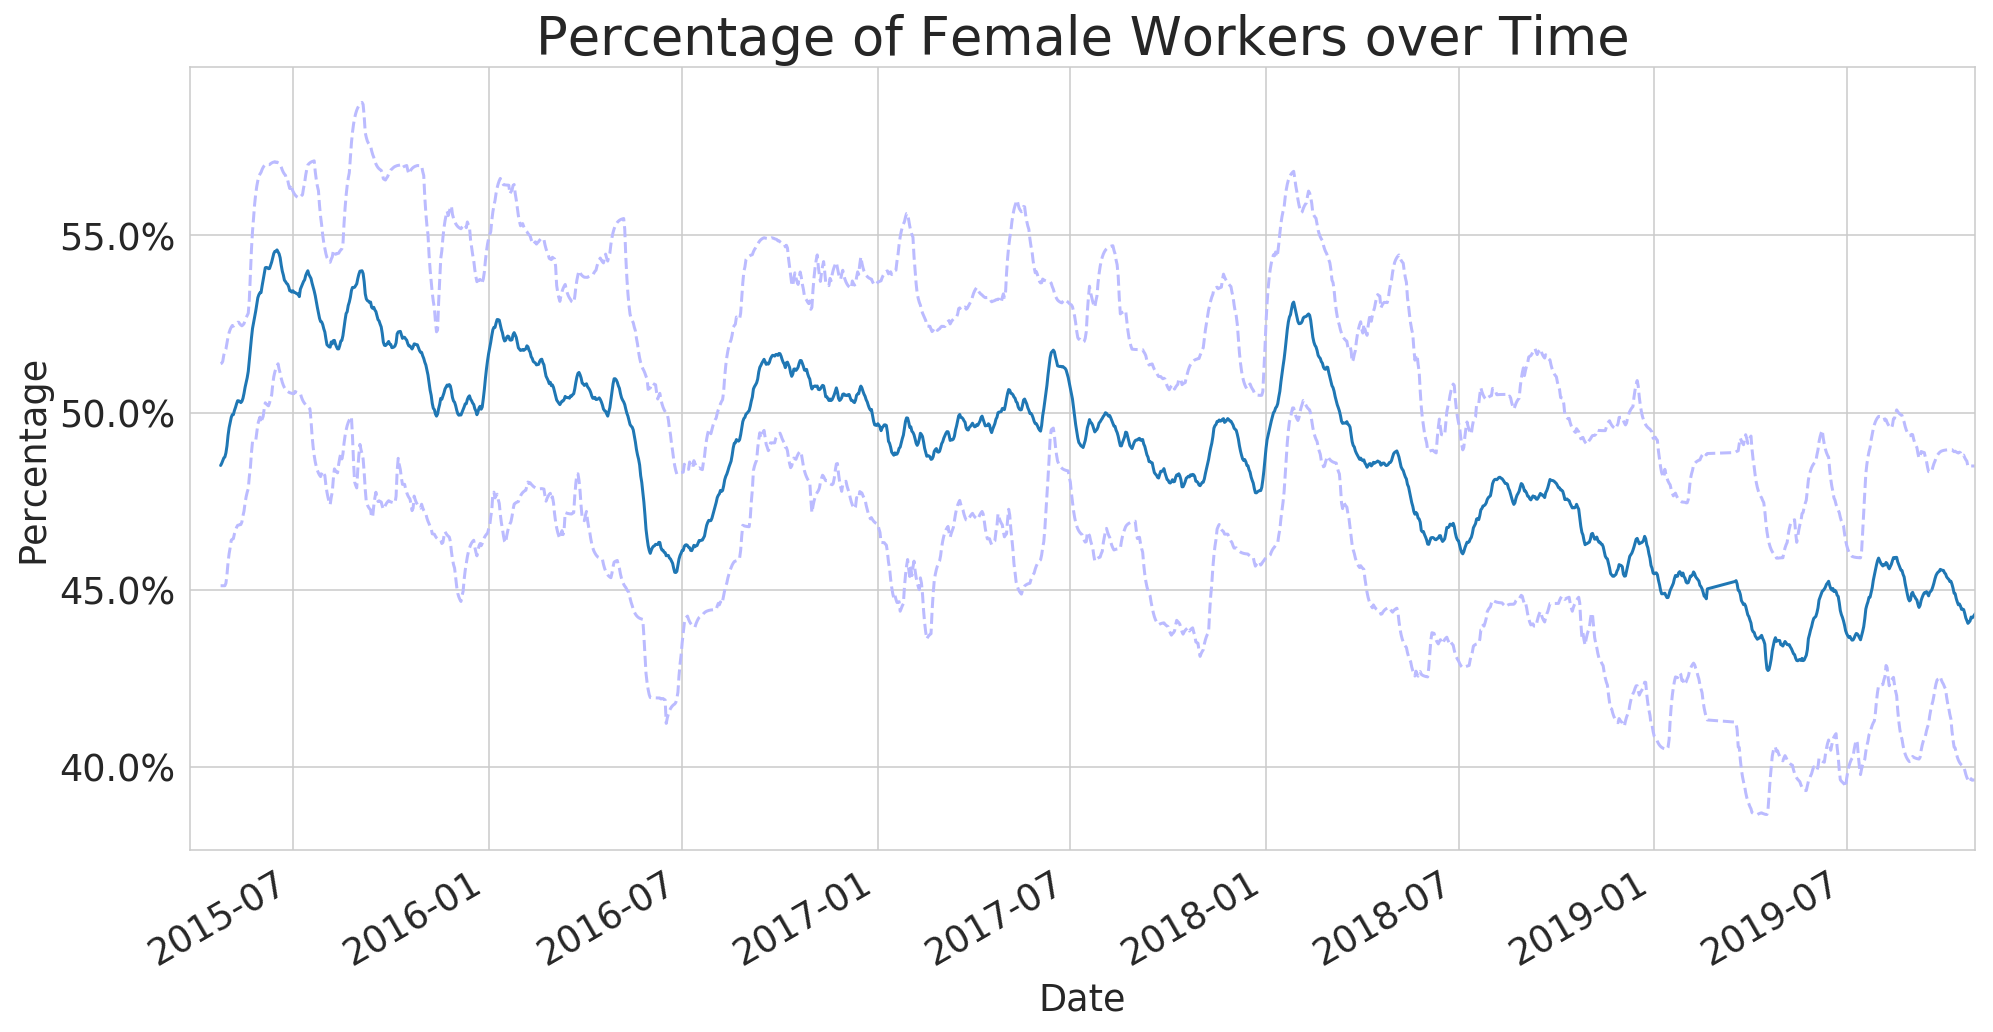

In [44]:
time_plot(data = 100*gender_table['female'], 
          title = 'Percentage of Female Workers over Time', 
          filename = 'plots/gender-female.pdf', 
          confidence=True)

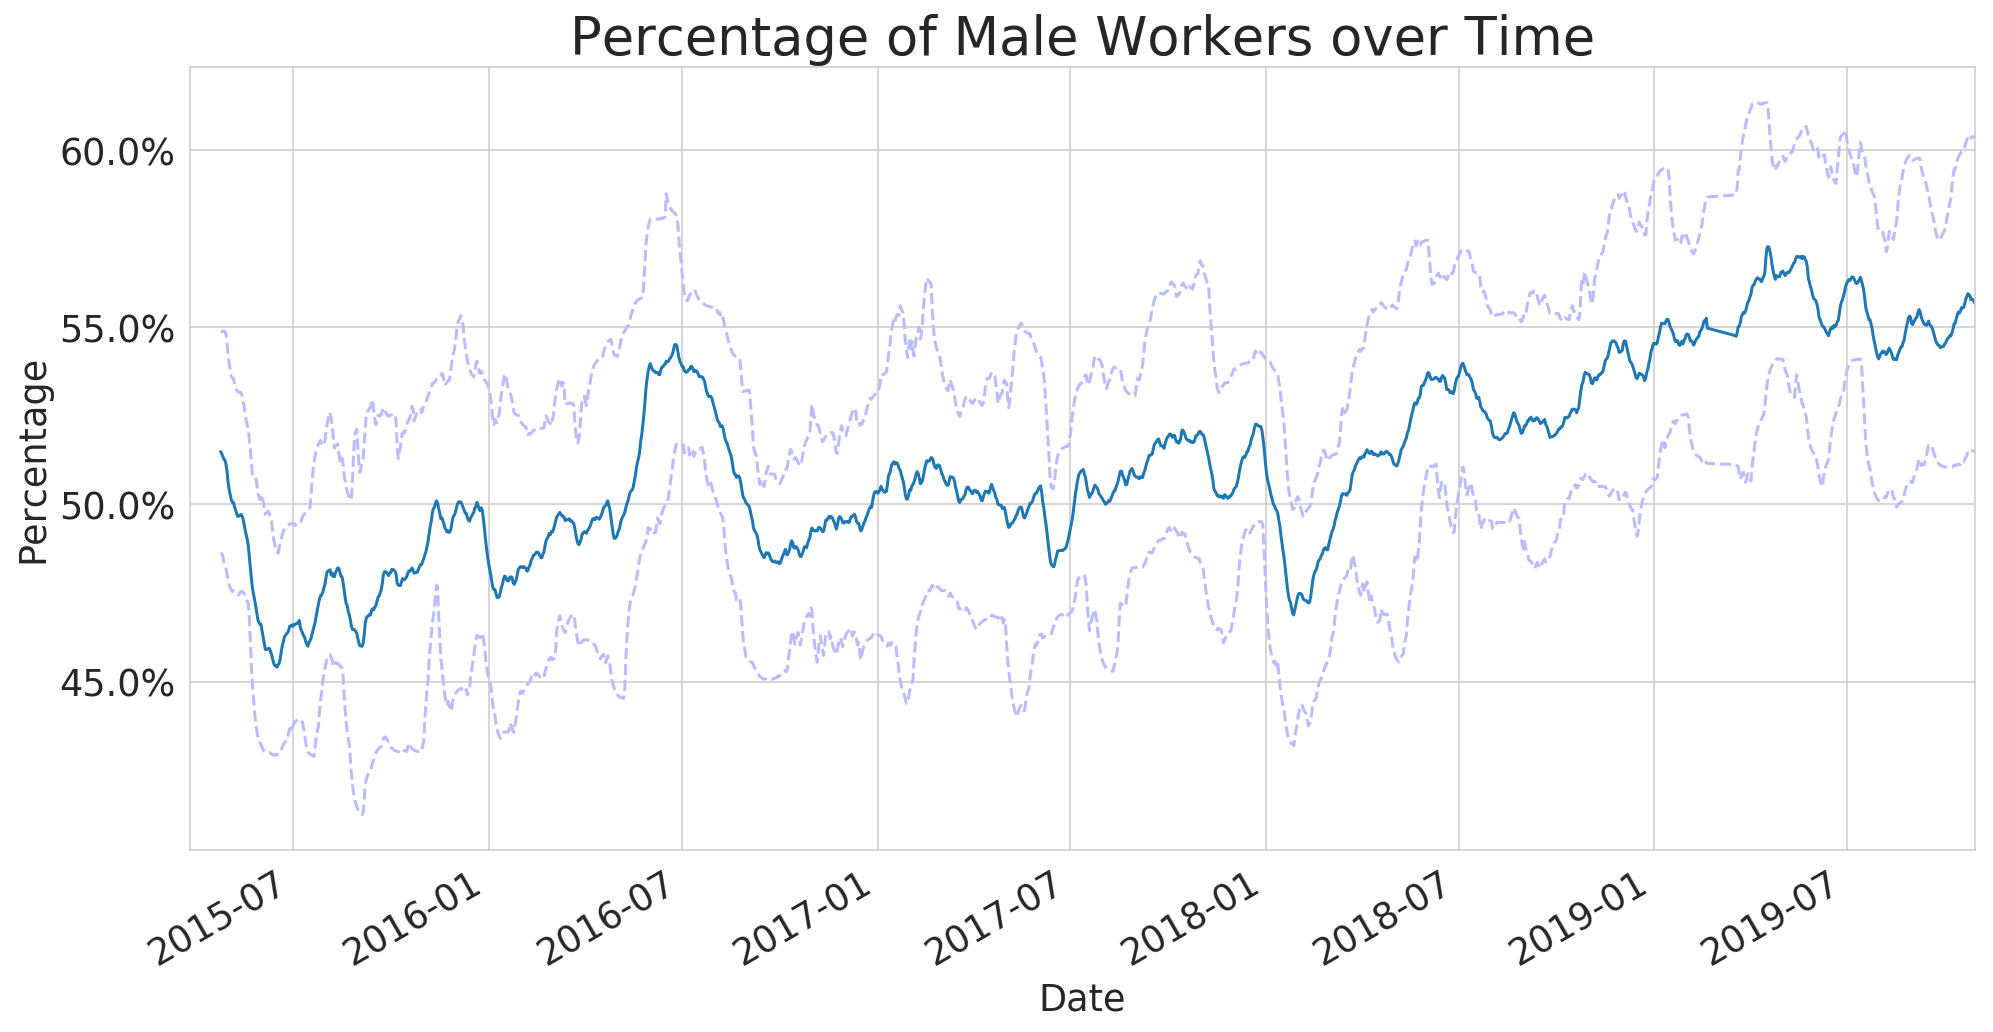

In [45]:
time_plot(data = 100*gender_table['male'], 
          title = 'Percentage of Male Workers over Time', 
          filename = 'plots/gender-male.pdf', 
          confidence=True)

### Gender by Country

In [ ]:
gender_by_country = pd.pivot_table(data=df,
                             values='worker_id', 
                             aggfunc=np.count_nonzero,
                             index=df.location_country,
                             columns=df.gender)

In [ ]:

# Keep only US and India
gender_by_country = gender_by_country[gender_by_country.index.isin(['US', 'IN', 'CA', 'GB', 'BR', 'IT', 'DE', 'PH', 'VE'])]
# Normalize and keep percentages
gender_by_country_perc = gender_by_country.apply(lambda x: 100*x / float(x.sum()), axis=1).round(2)
gender_by_country_perc = gender_by_country_perc.reindex(['US', 'IN', 'CA', 'GB', 'BR', 'IT', 'DE', 'PH', 'VE'])

In [ ]:
gender_by_country.sum()

gender
female    76478.0
male      77772.0
dtype: float64

In [ ]:
gender_by_country.sum()/gender_by_country.sum().sum()

gender
female    0.495806
male      0.504194
dtype: float64

In [ ]:
gender_by_country

gender             female     male
location_country                  
BR                  126.0    468.0
CA                  961.0   1263.0
DE                  177.0    429.0
GB                  560.0    994.0
IN                10840.0  19201.0
IT                  249.0    444.0
PH                  210.0    303.0
US                63274.0  54291.0
VE                   81.0    379.0

In [ ]:
gender_by_country_perc_df = gender_by_country_perc[['female','male']]

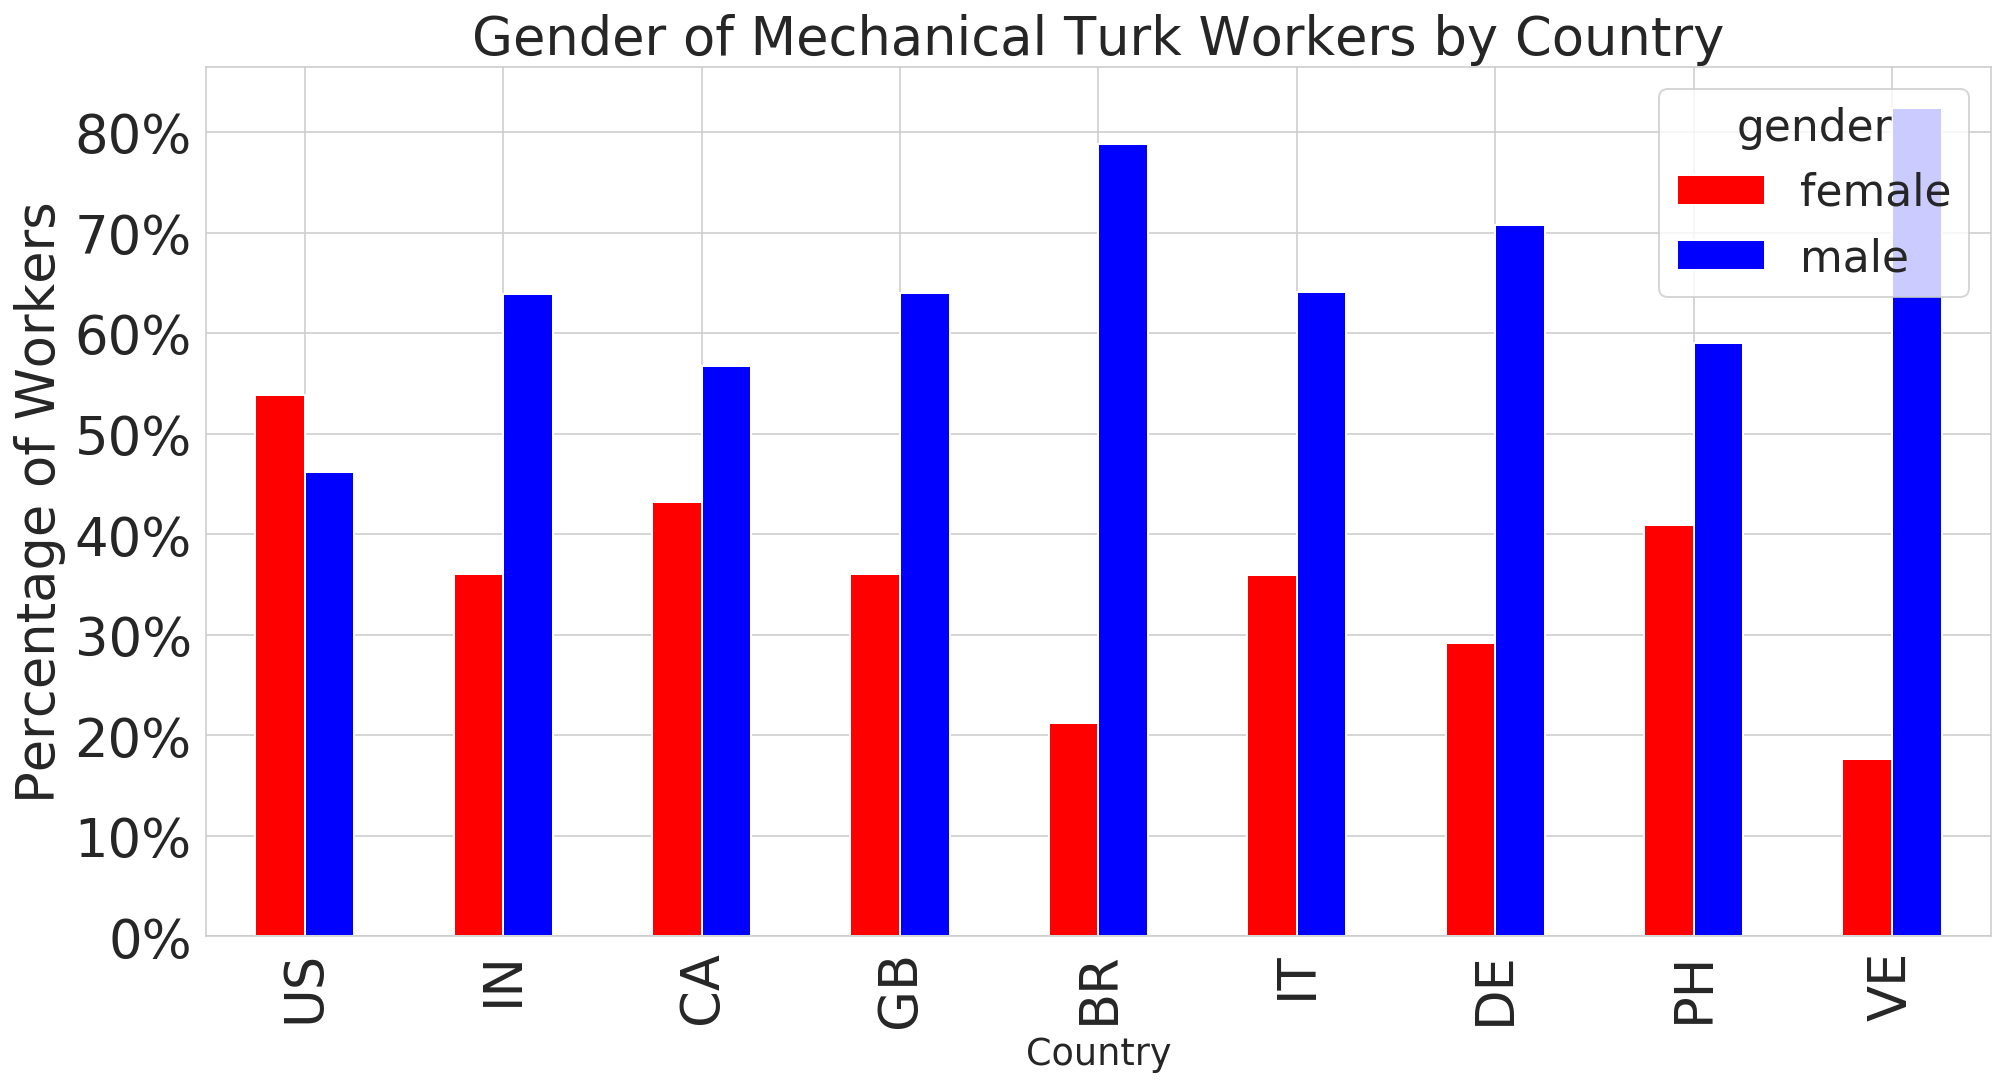

In [ ]:
ax = gender_by_country_perc_df.plot.bar(fontsize='large', color=['red','blue'])
ax.set_title("Gender of Mechanical Turk Workers by Country", fontsize='large')
ax.set_xlabel("Country", fontsize='small')
ax.set_ylabel("Percentage of Workers", fontsize='large')

fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
yticks = mtick.FormatStrFormatter(fmt)
ax.yaxis.set_major_formatter(yticks)

fig = ax.get_figure()
fig.savefig('plots/gender.pdf', bbox_inches='tight')

### Gender by Country over Time

In [ ]:
gender_table_us = pd.crosstab(index=df[df.location_country=='US'].date, columns=df[df.location_country=='US'].gender, 
                            values='worker_id', aggfunc=np.count_nonzero, normalize='index')

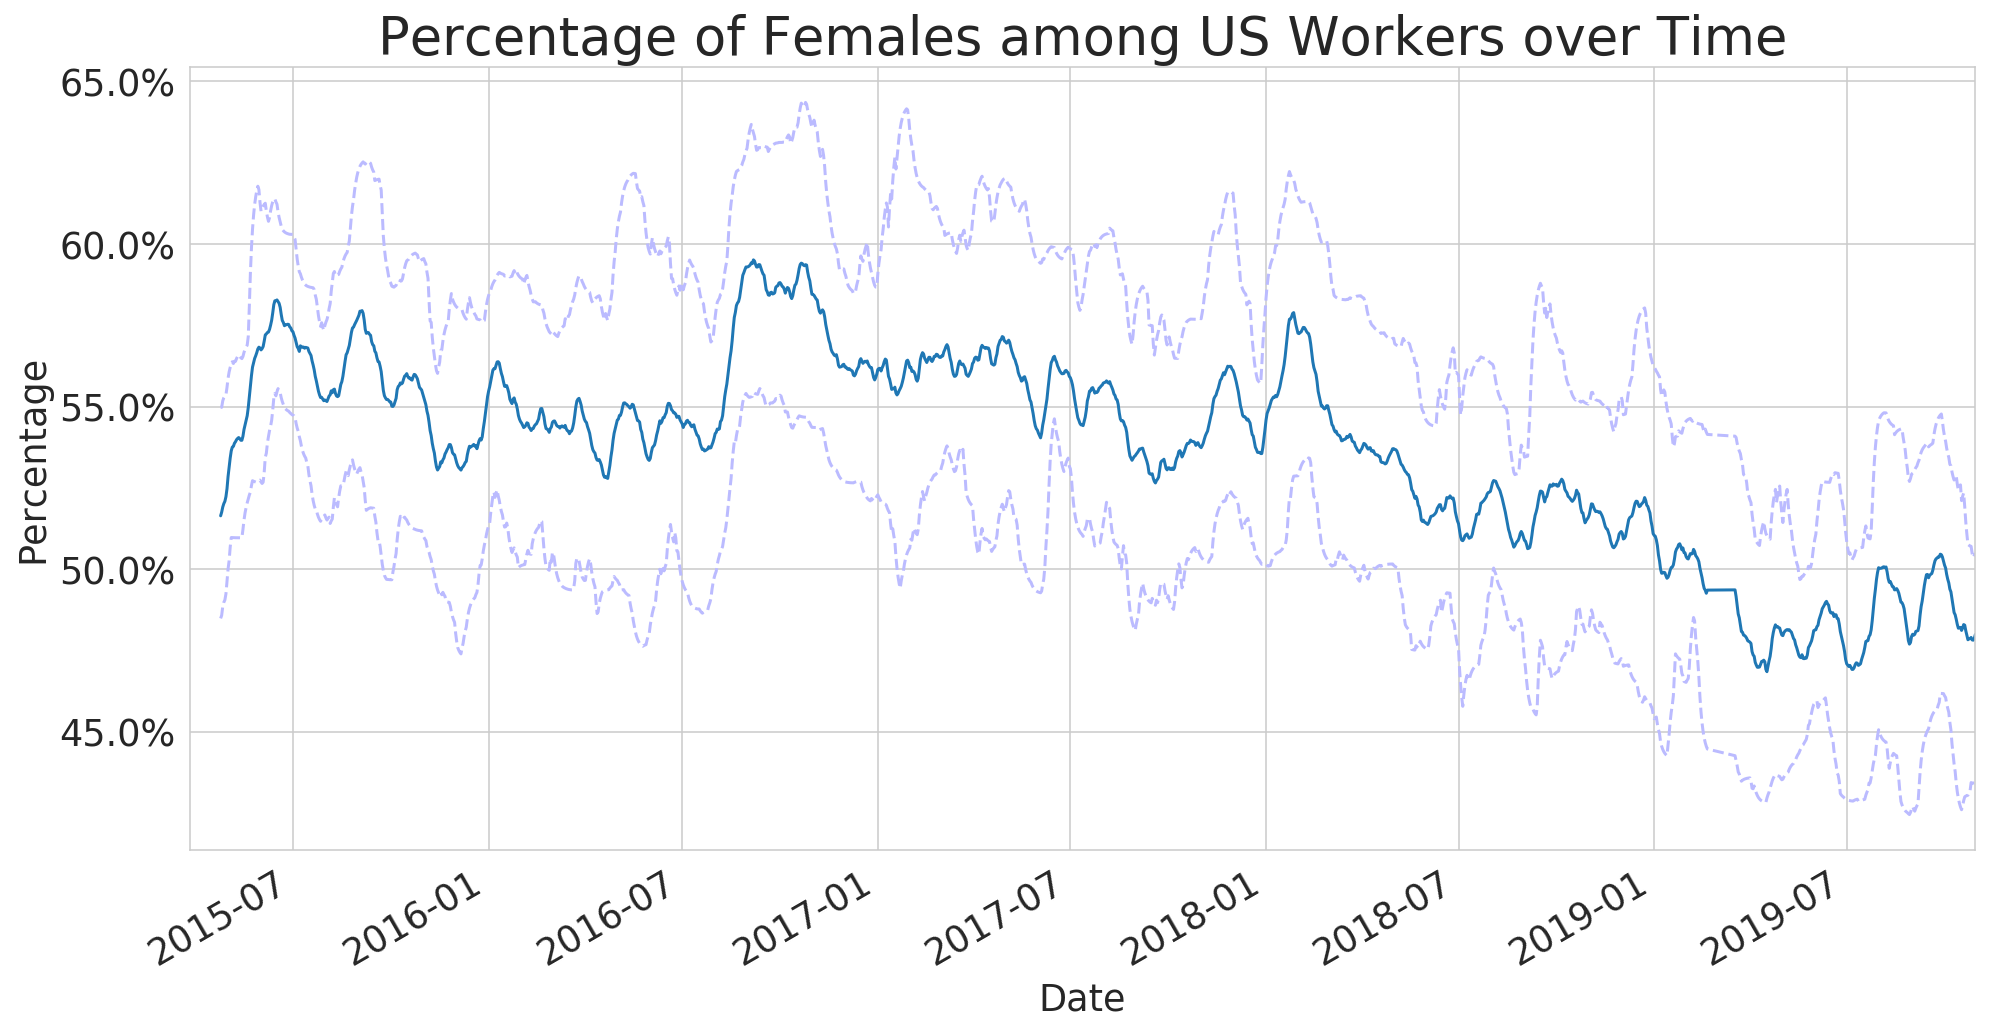

In [ ]:
time_plot(data = 100*gender_table_us['female'], 
          title = 'Percentage of Females among US Workers over Time', 
          filename = 'plots/gender-female-usa.pdf', 
          confidence=True)

In [ ]:
gender_table_in = pd.crosstab(index=df[df.location_country=='IN'].date, columns=df[df.location_country=='IN'].gender, 
                            values='worker_id', aggfunc=np.count_nonzero, normalize='index')

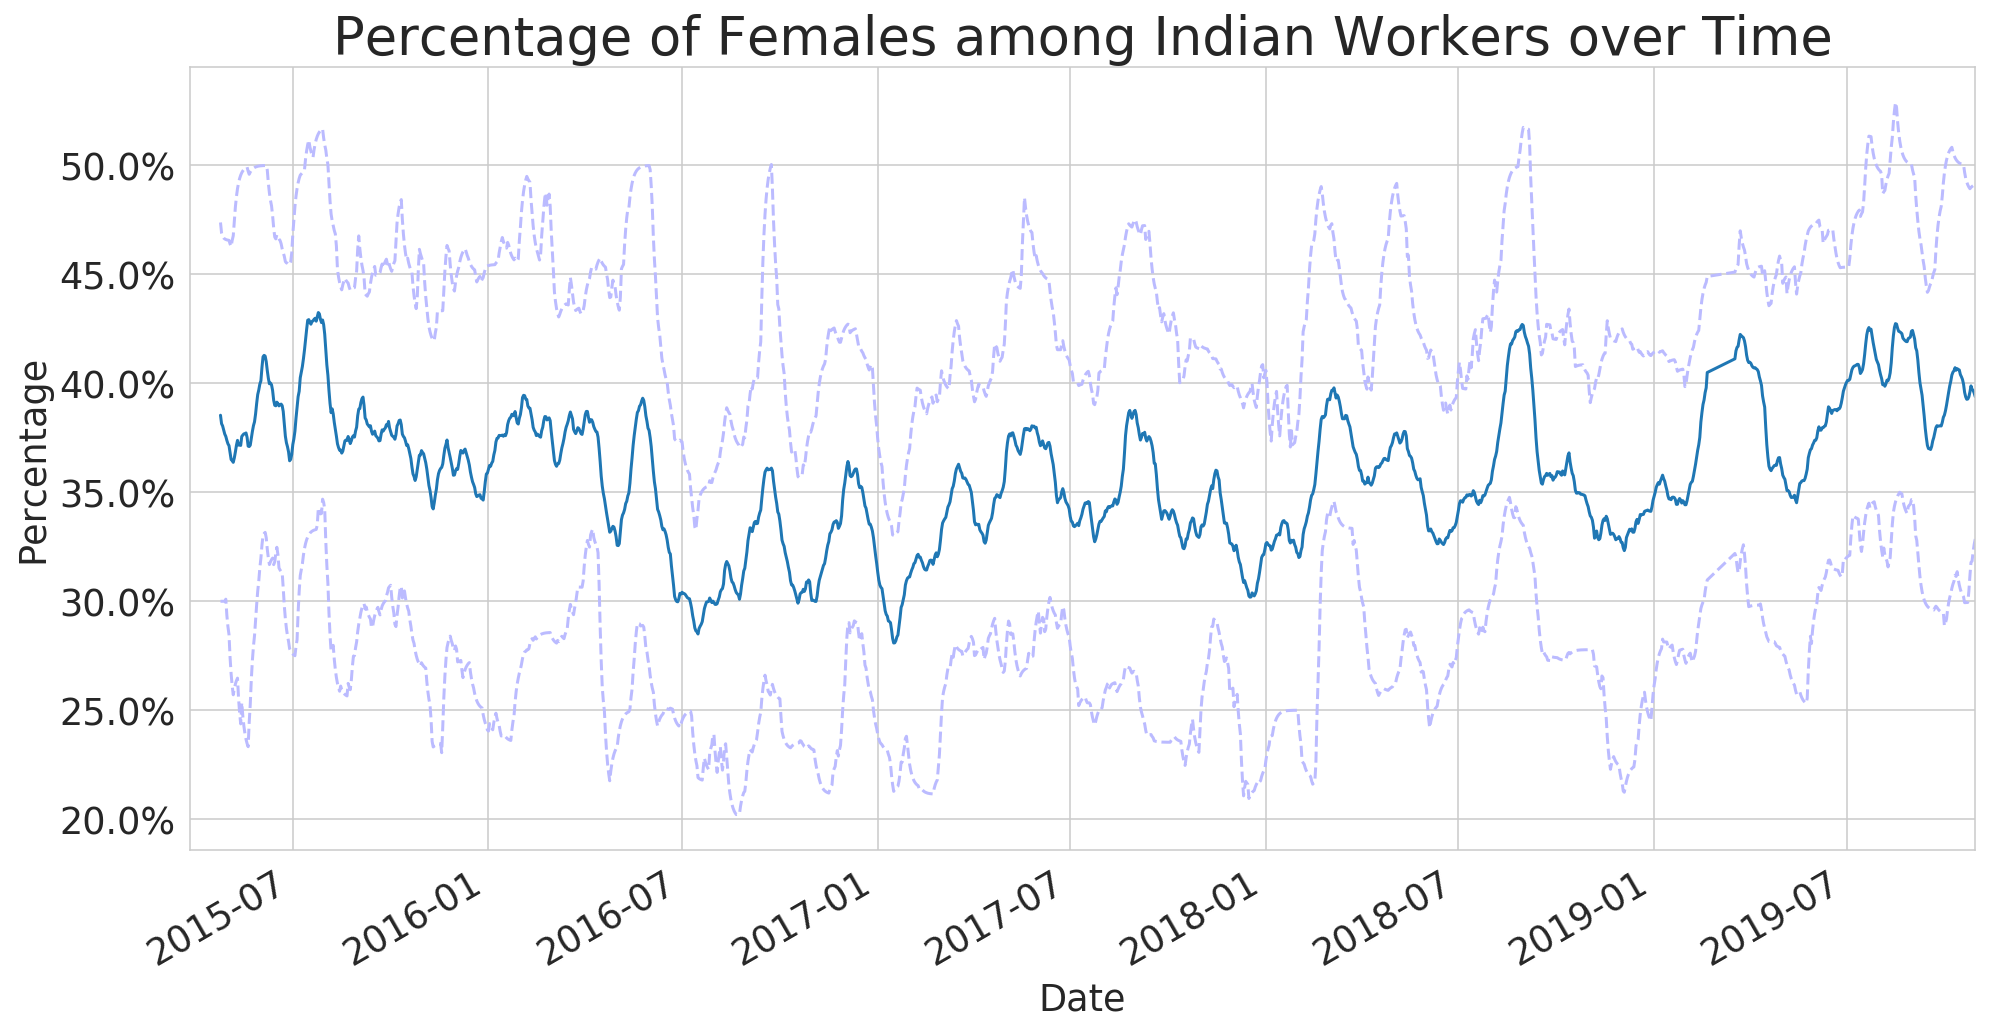

In [ ]:
time_plot(data = 100*gender_table_in['female'], 
          title = 'Percentage of Females among Indian Workers over Time', 
          filename = 'plots/gender-female-india.pdf', 
          confidence=True)

### Year of Birth

In [ ]:
yob_table = pd.crosstab(index=df.date, columns=df.year_of_birth, 
                            values='worker_id', aggfunc=np.count_nonzero, normalize='index')

In [ ]:
# yob_table.head(5)

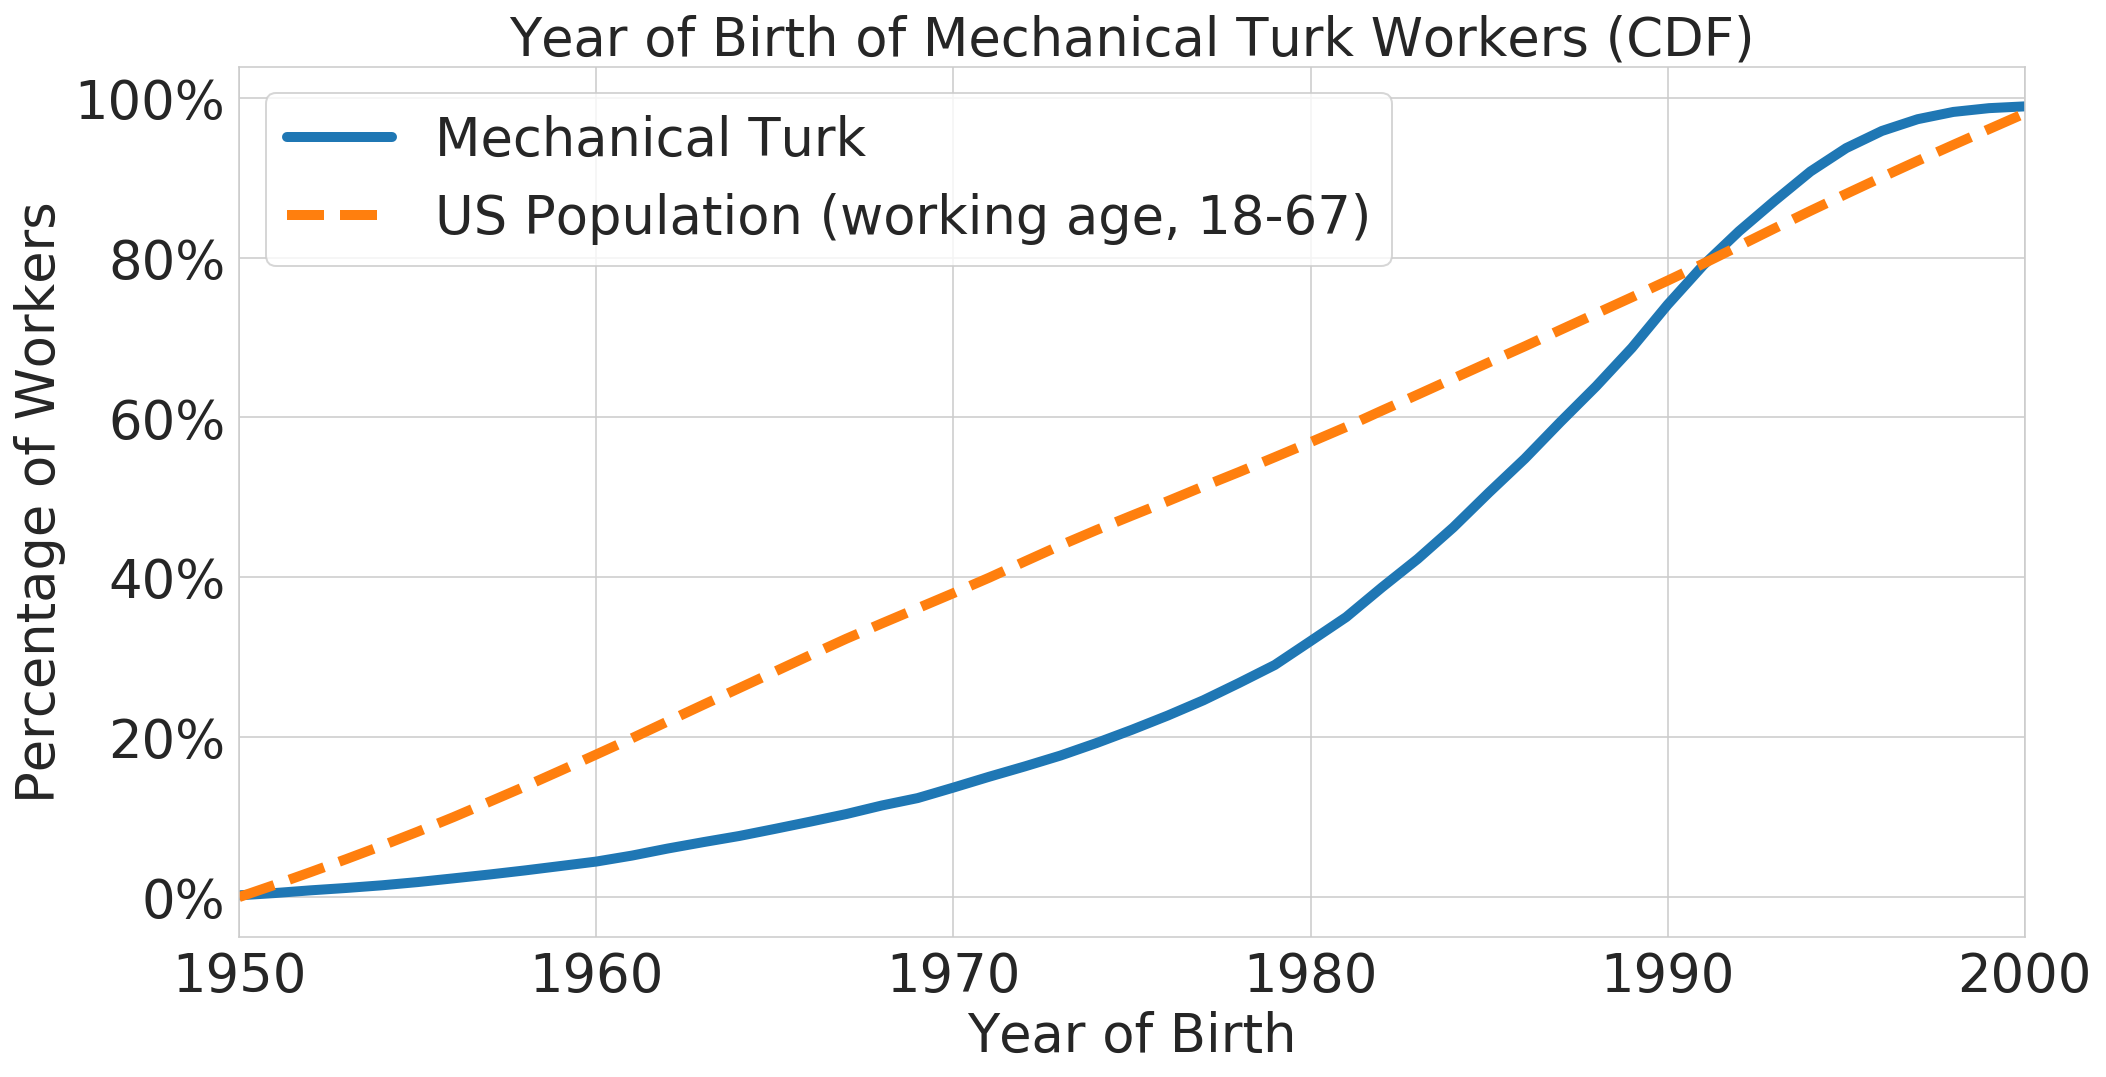

In [ ]:
# Limit data to working age
years = [y for y in range(1950,2001)]

# 
yob_df = (100*yob_table[years].mean()).cumsum()
ax = yob_df.plot(fontsize='large', linewidth=5)
ax.set_title("Year of Birth of Mechanical Turk Workers (CDF)", fontsize='large')
ax.set_xlabel("Year of Birth", fontsize='large')
ax.set_ylabel("Percentage of Workers", fontsize='large')

fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
yticks = mtick.FormatStrFormatter(fmt)
ax.yaxis.set_major_formatter(yticks)

census = pd.read_csv("census.csv", sep='\t', names  = ['Year of Birth', 'U', 'US Population'])
census.set_index('Year of Birth', inplace=True)
census.drop('U',axis=1, inplace=True)
census.sort_index(inplace=True)
census['US Population'] = 100*census['US Population']
census.plot(ax=ax, linestyle='--', linewidth=5)

ax.legend(['Mechanical Turk', 'US Population (working age, 18-67)'], fontsize='large')

fig = ax.get_figure()
fig.savefig('plots/yearofbirth.pdf', bbox_inches='tight')

In [ ]:

census.dtypes

US Population    float64
dtype: object

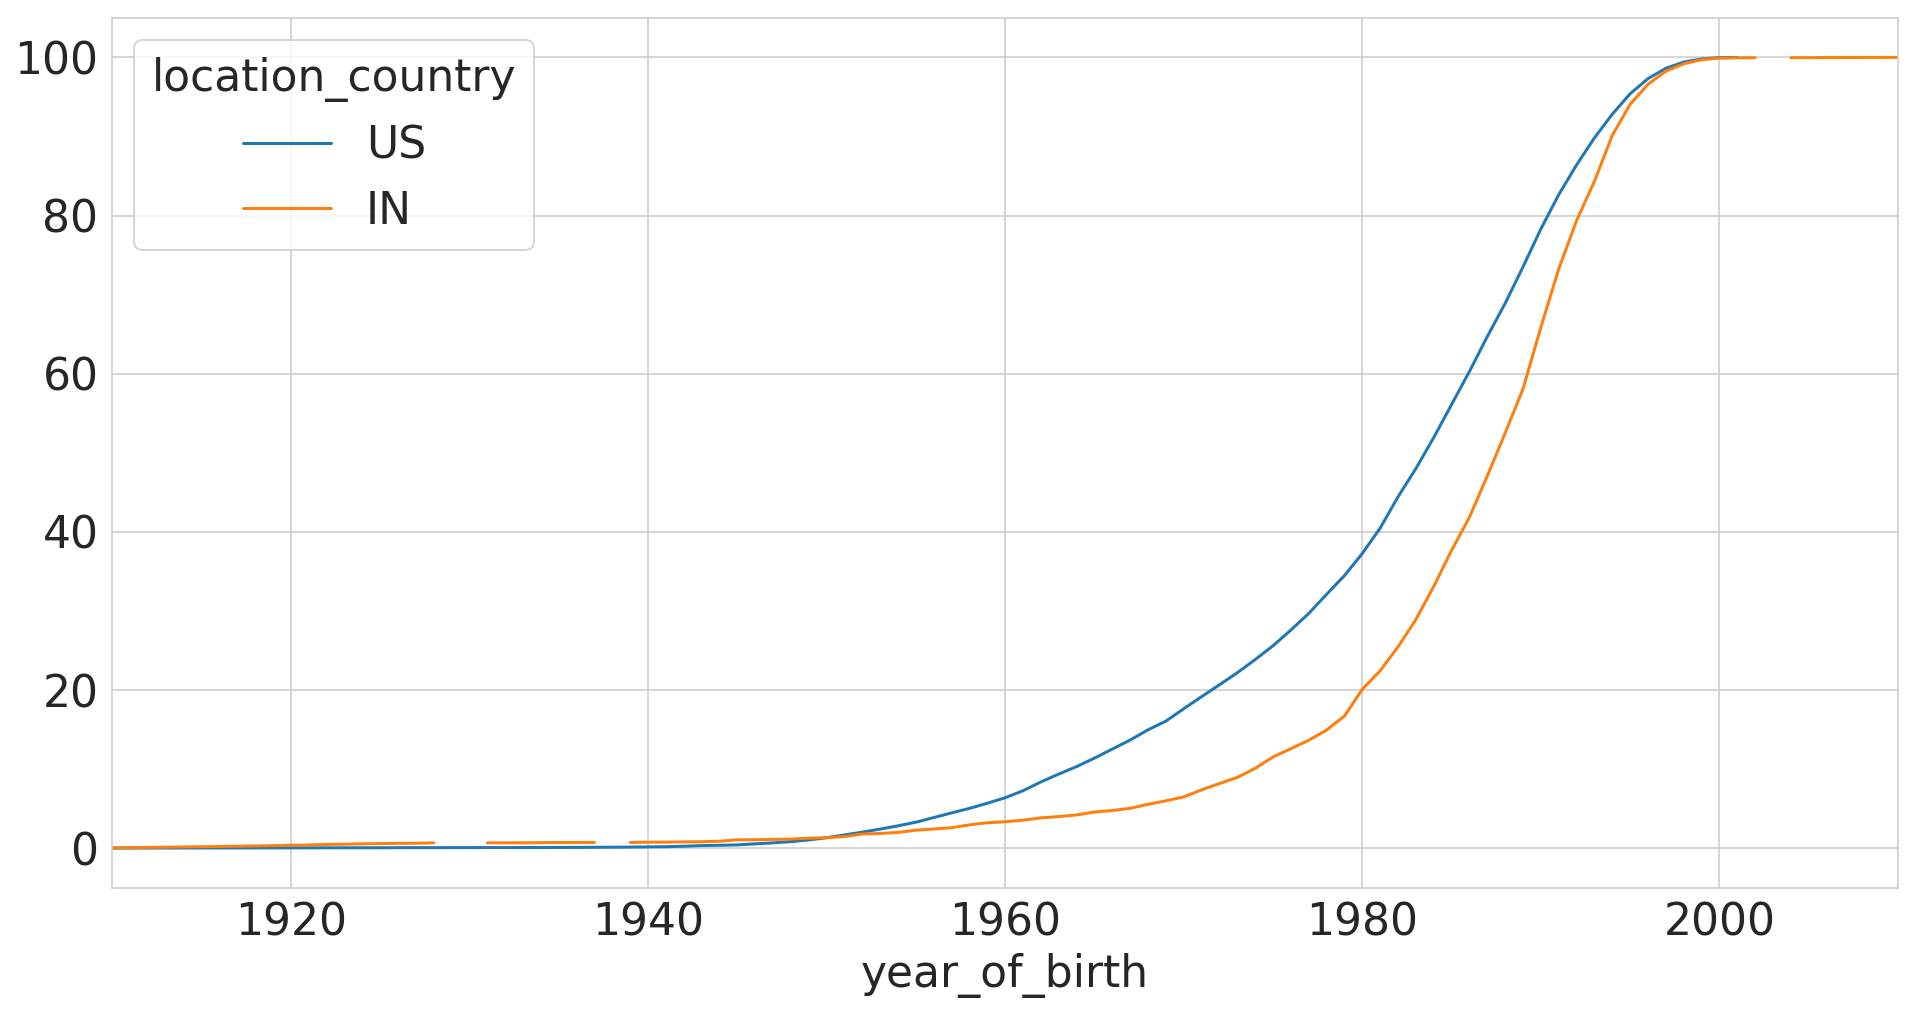

In [ ]:
age_by_country = pd.pivot_table(data=df,
                             values='worker_id', 
                             aggfunc=np.count_nonzero,
                             index=df.year_of_birth,
                             columns=df.location_country)

age_by_country = age_by_country[['US', 'IN']]
age_by_country = 100*age_by_country / age_by_country.sum()
# age_by_country.plot(ax = ax)
# fig
age_by_country.cumsum().plot()

In [ ]:
# Keep only US and India

# Normalize and keep percentages
age_by_country_perc = age_by_country.apply(lambda x: 100*x / float(x.sum()), axis=1).round(2)
# age_by_country_perc = age_by_country_perc.reindex(['US', 'IN', 'CA', 'GB', 'PH', 'DE'])

In [ ]:
age_by_country_perc

location_country      US      IN
year_of_birth                   
1910               18.27   81.73
1911               16.97   83.03
1912                3.52   96.48
1913                7.85   92.15
1914                6.00   94.00
1915                4.86   95.14
1916                3.52   96.48
1917                2.76   97.24
1918               14.56   85.44
1919                7.85   92.15
1920                2.92   97.08
1921                3.52   96.48
1922                6.51   93.49
1923                6.00   94.00
1924                7.85   92.15
1925                5.37   94.63
1926               17.29   82.71
1927               43.39   56.61
1928                4.08   95.92
1929              100.00     NaN
1930              100.00     NaN
1931               64.14   35.86
1932               43.39   56.61
1933               33.82   66.18
1934               26.74   73.26
1935               20.35   79.65
1936               33.82   66.18
1937               84.90   15.10
1938              100.00     NaN
1939               84.29   15.71
...                  ...     ...
1981               57.77   42.23
1982               56.65   43.35
1983               50.84   49.16
1984               48.39   51.61
1985               47.84   52.16
1986               49.90   50.10
1987               45.87   54.13
1988               43.55   56.45
1989               45.25   54.75
1990               38.12   61.88
1991               37.01   62.99
1992               38.12   61.88
1993               40.70   59.30
1994               34.04   65.96
1995               39.68   60.32
1996               43.09   56.91
1997               44.01   55.99
1998               45.68   54.32
1999               43.29   56.71
2000               45.79   54.21
2001               40.76   59.24
2002                 NaN  100.00
2003              100.00     NaN
2004                 NaN  100.00
2005                 NaN  100.00
2006               20.35   79.65
2007                 NaN  100.00
2008               20.35   79.65
2009                 NaN  100.00
2010                 NaN  100.00

[101 rows x 2 columns]

##### Decade of birth

In [ ]:
df['yob_decade'] = df['year_of_birth'].apply(lambda x: str(int(round(x,-1)))+'-'+str(int(round(x,-1))+9))
decades = ['1950-1959', '1960-1969', '1970-1979', '1980-1989', '1990-1999','2000-2009']
yob_table = pd.crosstab(index=df.date, columns=df.yob_decade, 
                            values='worker_id', aggfunc=np.count_nonzero, normalize='index')

In [ ]:
time_plot(100*yob_table[decades], "Year of Birth of Workers", 
          filename = 'plots/decateofbirth.pdf', confidence = False, legend = True)

#### Indian workers are *slightly* younger

In [ ]:
data = pd.DataFrame(df[df.location_country=='IN'])
yob_table_in = pd.crosstab(index=data.date, columns=data.yob_decade, 
                            values='worker_id', aggfunc=np.count_nonzero, normalize='index')

In [ ]:
time_plot(100*yob_table_in[decades], "Year of Birth of Indian Workers", 
          'plots/yearofbirth-indian.pdf', confidence = False, legend = True)

### Marital Status

In [ ]:
marital_status = pd.pivot_table(data=df,
                             values='worker_id', 
                             aggfunc=np.count_nonzero,
                             index=df.marital_status)

In [ ]:
status = set(df.marital_status)
status.discard('None')
status.discard('separated')
status.discard('widowed')
status = sorted(status)
status

In [ ]:
marital_status = 100* marital_status / marital_status.sum()
marital_status = marital_status.T[status].T

In [ ]:
marital_status

In [ ]:
ax = marital_status.plot.bar(fontsize='large')
ax.set_title("Marital Status of Workers", fontsize='large')
ax.set_xlabel("Marital Status", fontsize='small')
ax.set_ylabel("Percentage of Workers", fontsize='large')
ax.legend([''])

fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
yticks = mtick.FormatStrFormatter(fmt)
ax.yaxis.set_major_formatter(yticks)

fig = ax.get_figure()
fig.savefig('plots/marital-status.pdf', bbox_inches='tight')

In [ ]:
married_table = pd.crosstab(index=df.date, columns=df.marital_status, 
                            values='worker_id', aggfunc=np.count_nonzero, normalize='index')

In [ ]:
status = set(df.marital_status)
status.discard('None')
status.discard('separated')
status.discard('widowed')
status = sorted(status)
status

In [ ]:
time_plot(100*married_table[status], "Marital Status of Workers", 
          'plots/marital-status.pdf', confidence = False, legend = True)

In [ ]:
married_table_in = pd.crosstab(index=df[df.location_country=='IN'].date, columns=df[df.location_country=='IN'].marital_status, 
                            values='worker_id', aggfunc=np.count_nonzero, normalize='index')

In [ ]:
status = set(df.marital_status)
status.discard('None')
status.discard('separated')
status.discard('widowed')
status.discard('engaged')
status.discard('divorced')
status.discard('cohabitating')
status = sorted(status)
status

In [ ]:
time_plot(married_table_in[status], "Marital Status of Indian Workers",
          'plots/marital-status-indian.pdf', confidence = False, legend = True)

### Household Size



In [ ]:
hhsize_table = pd.crosstab(index=df.date, columns=df.household_size, 
                           values='worker_id', aggfunc=np.count_nonzero, normalize='index')

In [ ]:
status = sorted(set(df.household_size))

In [ ]:
time_plot(hhsize_table[status], "Household Size",
          'plots/hhsize.pdf', confidence = False, legend = True)

#### HHSize for Single and Married People

In [ ]:
hhsize_table = pd.crosstab(index=df.date, columns=[df.household_size, df.marital_status], 
                           values='worker_id', aggfunc=np.count_nonzero, normalize='index')

In [ ]:
import itertools

marital = set(df.marital_status)
marital.discard('None')
marital.discard('separated')
marital.discard('widowed')
marital.discard('engaged')
marital.discard('divorced')
marital.discard('cohabitating')
# marital.discard('single')
marital.discard('married')


hhsize = set(df.household_size)
# hhsize.discard('1')
# hhsize.discard('2')
# hhsize.discard('3')
# hhsize.discard('4')
# hhsize.discard('5+')

status = sorted(itertools.product(hhsize, marital))
status

In [ ]:
time_plot(100*hhsize_table[status], "Household Size for Singles", 'plots/hhsize-singles.pdf', confidence = False, legend = True)

In [ ]:
import itertools

marital = set(df.marital_status)
marital.discard('None')
marital.discard('separated')
marital.discard('widowed')
marital.discard('engaged')
marital.discard('divorced')
marital.discard('cohabitating')
marital.discard('single')
# marital.discard('married')


hhsize = set(df.household_size)
# hhsize.discard('1')
# hhsize.discard('2')
# hhsize.discard('3')
# hhsize.discard('4')
# hhsize.discard('5+')

status = sorted(itertools.product(hhsize, marital))
status

In [ ]:
time_plot(100*hhsize_table[status], "Household Size for Married", 'plots/hhsize-married.pdf', confidence = False, legend = True)

### Household Income

In [ ]:
df['household_income'] = df['household_income'].apply(lambda x:x.replace('$',''))
income = pd.pivot_table(data=df[df.location_country=='US'],
                             values='worker_id', 
                             aggfunc=np.count_nonzero,
                             index=df[df.location_country=='US'].household_income)

In [ ]:
status = sorted(set(df.household_income))
# Reconfiguring the order
status[0],  status[1], status[7] = status[7], status[0], status[1]
income = income.reindex(status)
income = income / income.sum()
income_df = income.cumsum()*100
income_df

In [ ]:
# https://en.wikipedia.org/wiki/Household_income_in_the_United_States
census_income_dict = [
{'household_income': 'Less than 10,000', 'US Population' : 3.67},
{'household_income': '10,000-14,999',  'US Population'  : 7.14},
{'household_income': '15,000-24,999',  'US Population' : 18.01},
{'household_income': '25,000-39,999',  'US Population' : 33.63},
{'household_income': '40,000-59,999',  'US Population' : 50.83},
{'household_income': '60,000-74,999',  'US Population' : 60.79},
{'household_income': '75,000-99,999',  'US Population' : 73.45},
{'household_income': '100,000 or more',  'US Population' : 100},   
]
census = pd.DataFrame(census_income_dict)
census.set_index('household_income', inplace=True)


In [ ]:
census

In [ ]:
df_income = income_df.join(census)
df_income.drop('100,000 or more', inplace=True)

In [ ]:
rename_dict = {
    'Less than 10,000': 10000,
    '10,000-14,999':  15000,
    '15,000-24,999':  25000,
    '25,000-39,999': 40000,
    '40,000-59,999': 60000,
    '60,000-74,999': 75000,
    '75,000-99,999': 100000}

df_income.rename(index=rename_dict, inplace=True)
df_income

In [ ]:
tmp = pd.DataFrame([{'household_income': 0, 'US Population':0, 'worker_id': 0}]).set_index('household_income')
df_income = df_income.append(tmp).sort_index()

In [ ]:
ax = df_income['worker_id'].plot(fontsize='large', linewidth=5)
ax = df_income['US Population'].plot(fontsize='large', linewidth=5, linestyle='--', ax = ax)

fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
yticks = mtick.FormatStrFormatter(fmt)
ax.yaxis.set_major_formatter(yticks)
ax.set_xlim([0,100000])


ax.set_title("Household Income of of Mechanical Turk Workers (CDF)", fontsize='large')
ax.set_xlabel("Household Income", fontsize='large')
ax.set_ylabel("Percentage of Workers", fontsize='large')

ax.legend(['Mechanical Turk', 'US Population'], fontsize='large')

fig = ax.get_figure()
fig.savefig('plots/income.pdf', bbox_inches='tight')

In [ ]:
hhincome_table = pd.crosstab(index=df.date, columns=df.household_income, 
                           values='worker_id', aggfunc=np.count_nonzero, normalize='index')

status = sorted(set(df.household_income))

# Reconfiguring the order
status[0],  status[1], status[7] = status[7], status[0], status[1]
status

In [ ]:
fm = hhincome_table[sorted(status)].ewm(span=30).mean()
fs = hhincome_table[sorted(status)].ewm(span=30).std() 
plt.figure(figsize = (30,20))
plt.tick_params(labelsize=30)

incomes = [fm[d] for d in status]

plt.stackplot(fm.index, incomes, alpha=0.75)
plt.ylim([0.0,1.0])

ax = plt.gca()
ax.set_title("Household Income", fontsize='x-large', y=1.05)
ax.set_ylabel("Percentage of Workers", fontsize='x-large')
ax.set_xlabel("Date", fontsize='x-large')


legend = []
for stat in status:
    s = stat.replace('$','')
    legend.append(s)
    
ax.legend(legend, fontsize='x-large', fancybox=True, frameon = True, loc="upper center", ncol=4, 
         bbox_to_anchor=(0.5, -0.15))